In [3]:
"""
필요한 모듈 및 프레임워크를 잘 생각하고 넣자
"""
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pandas as pd 
import os

In [17]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8755743692940199633
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1391594292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15005958397860498181
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [32]:

#데이터 불러오기
"""
첫 모델에서는 기본 형상에 레이놀즈 수 스칼라를 더한 후 2를 나눠준 함수를 CNN모델으로
학습
두번째 모델에서는 위 방식에 원 형상이미지 인풋을 추가하여 학습 시켜 출력시 
형상이미지의 정확도를 늘릴 예정
세번째 모델에서는 순수 입력 이미지를 CNN모델으로 학습 레이놀즈수는 다중입력으로
특별한 신경망을 지나지 않고 입력으로 사용하는 wide&deeplearning이용
네번째 모델은 생각해봄 
"""
#test [:,:65536]인풋 이미지,[:,65536]레이놀즈수,[:,65537:]타겟 이미지
#test2[:,:65536]인풋 이미지,[:,65536:131072]레이놀즈 더한 배열,[:,131072:]타겟 이미지
#데이터 셋 불러 오기
dataset = np.load('test.npy', allow_pickle=True)
dataset_test = np.load('test2.npy', allow_pickle=True)
shape_inputs = dataset[:,:65536]
reynols = dataset[:,65536]
outputs = dataset[:,65537:]
#1 더하고 나눈 인풋
RI_inputs = dataset_test[:,65536:131072]
print(RI_inputs.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =0)
print(X_train.shape[0])

(638, 65536)
510


In [32]:
"""
첫모델
"""
dataset = np.load('test2.npy', allow_pickle=True)
X = dataset[:,65536:131072]
Y = dataset[:,131072:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =1)
X_test, X_val,Y_test, Y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=1)
X_train = X_train.reshape(X_train.shape[0], 256,256,1)
X_test = X_test.reshape(X_test.shape[0], 256,256,1)
X_val = X_val.reshape(X_val.shape[0], 256,256,1)
tf.random.set_seed(44)

RI_inputs = keras.Input(shape = (256,256,1), name = 'RI_input')

Con1 = layers.Conv2D(16,3,activation = 'elu', padding='same')(RI_inputs)
Max1 = layers.MaxPool2D(pool_size=(2))(Con1)

Con2 = layers.Conv2D(32, 3, activation = 'elu', padding='same')(Max1)
Max2  =layers.MaxPool2D(pool_size=(2))(Con2)

Con3 = layers.Conv2D(64, 3, activation = 'elu', padding='same')(Max2)
Max3  =layers.MaxPool2D(pool_size=(2))(Con3)

Con4 = layers.Conv2D(128, 3, activation = 'elu', padding='same')(Max3)
Max4=layers.MaxPool2D(pool_size=(2))(Con4)

Con5 = layers.Conv2D(256, 3, activation = 'elu', padding='same')(Max4)
Max5=layers.MaxPool2D(pool_size=(2))(Con5)

Con6 = layers.Conv2D(512, 3, activation = 'elu', padding='same')(Max5)
Max6=layers.MaxPool2D(pool_size=(2))(Con6)

flat = layers.Flatten()(Max6)

output =  layers.Dense(49152)(flat)


model = keras.Model(inputs = RI_inputs,outputs=output, name = 'test1')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])

#history = model.fit(X_train,Y_train,epochs=30, validation_data=(X_val, Y_val), batch_size=10)


#ist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32, callbacks = [callbacks,checkpoint])

model.summary()

Model: "test1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RI_input (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        18496 

In [2]:
"""
전처리 후 npy파일로 저장하기위한 코드
일단 사이즈는 강제로 256,256으로 변환시키는 방식
각 이미지를 일차원 배열로 생성
사용시에는 인덱스에 맞게 꺼내서 사용할 예정
"""
import numpy as np
import re
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
current_path = os.path.abspath('')
input_img_path = os.path.join(current_path,"input_img")
target_img_path = os.path.join(current_path,"target_img")
input_files = os.listdir(input_img_path)
target_files = os.listdir(target_img_path)
datasets = []
i = 0
test_data = np.array([])
for input_file, target_file in zip(input_files, target_files):
    dataset= []
    plus_input = []
    mul_input = []
    input_pro = []
    name = str(input_file)
    #레이놀즈 수 파일 이름에서 추출
    R = float(name[5]+"."+name[6])*10**int(name[7])/(1.3*(10**6))
    #인풋 이미지 파일 경로로 들어가서 인풋 이미지 전처리 과정
    os.chdir(input_img_path)
    input_img = Image.open(input_file)
    #이미지 리사이징
    input_img = input_img.resize((256, 256))
    #이미지 nunpy배열로 변환
    input_img_tensor = img_to_array(input_img)
    input_img_tensor = input_img_tensor.reshape(196608).astype('float64')/ 255
    #타겟 이미지 파일 경로로 들어가서 전처리 과정
    os.chdir(target_img_path)
    target_img = Image.open(target_file)
    target_img = target_img.resize((256,256))
    #타겟 이미지는 1차원 배열로 생성
    target_img_tensor = img_to_array(target_img)
    target_img_tensor = target_img_tensor.reshape(196608).astype('float64')/ 255
    plus_input = (input_img_tensor +R)/2
    dataset = np.concatenate((input_img_tensor,plus_input), axis = 0)
    dataset = np.concatenate((dataset,target_img_tensor), axis = 0)
    datasets.insert(i,dataset)
    i += 1
    os.chdir('..')
datasets = np.array(datasets)
#[:,:196608]인풋 이미지,[:,196608:393216]레이놀즈수,[:,393216:]타겟 이미지
np.save("test3.npy", datasets)
print(datasets.shape)

(520, 589824)


In [4]:
"""
일반적인 학습 모델은 출력 갯수의 한계가 있음을 알았다.
이번엔 오토인코더를 이용한 모델을 구성해 볼 생각이다
입력값은 레이놀즈 수와 이미지의 합(바이너리가 아닌 회색)
출력은 타겟 이미지
"""
#[:,:196608]인풋 이미지,[:,196608:393216]레이놀즈수,[:,393216:]타겟 이미지
dataset = np.load('test3.npy', allow_pickle=True)
X = dataset[:,196608:393216]
Y = dataset[:,393216:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =1)
X_test, X_val,Y_test, Y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=1)
X_train = X_train.reshape(X_train.shape[0], 256,256,3)
X_test = X_test.reshape(X_test.shape[0], 256,256,3)
X_val = X_val.reshape(X_val.shape[0], 256,256,3)
Y_train = Y_train.reshape(Y_train.shape[0], 256,256,3)
Y_test = Y_test.reshape(Y_test.shape[0], 256,256,3)
Y_val = Y_val.reshape(Y_val.shape[0], 256,256,3)

tf.random.set_seed(44)

RI_inputs = keras.Input(shape = (256,256,3), name = 'RI_input')

Con1 = layers.Conv2D(16, 3, activation = 'elu', padding = 'same')(RI_inputs)
Max1 = tf.keras.layers.MaxPool2D(pool_size=(2))(Con1)

Con2= layers.Conv2D(32, 3, activation = 'elu', padding = 'same')(Max1)
#x = tf.keras.layers.BatchNormalization()(x)
Max2 = tf.keras.layers.MaxPool2D(pool_size=(2))(Con2)

Con3 = layers.Conv2D(64, 3, activation = 'elu', padding = 'same')(Max2)
#x = tf.keras.layers.BatchNormalization()(x)
Max3 = tf.keras.layers.MaxPool2D(pool_size=(2))(Con3)

Con4 = layers.Conv2D(128, 3, activation = 'elu', padding = 'same')(Max3)
#x = tf.keras.layers.BatchNormalization()(x)
Max4 = tf.keras.layers.MaxPool2D(pool_size=(2))(Con4)

Con5 = layers.Conv2D(256, 3, activation = 'elu', padding = 'same')(Max4)
#x = tf.keras.layers.BatchNormalization()(x)
Max5 = tf.keras.layers.MaxPool2D(pool_size=(2))(Con5)

Con6 = layers.Conv2D(512, 3, activation = 'elu', padding = 'same')(Max5)

ConT1 = layers.Conv2DTranspose(256, 3, activation = 'elu', padding = 'same')(Con6)
Up1= layers.UpSampling2D((2,2))(ConT1)

ConT2 = layers.Conv2DTranspose(128, 3, activation = 'elu', padding = 'same')(Up1)
Up2 = layers.UpSampling2D((2,2))(ConT2)

ConT3 = layers.Conv2DTranspose(64, 3, activation = 'elu', padding = 'same')(Up2)
Up3 = layers.UpSampling2D((2,2))(ConT3)

ConT4 = layers.Conv2DTranspose(32, 3, activation = 'elu', padding = 'same')(Up3)
Up4 = layers.UpSampling2D((2,2))(ConT4)

ConT5 = layers.Conv2DTranspose(3, 3, activation = 'elu', padding = 'same')(Up4)
Up5 = layers.UpSampling2D((2,2))(ConT5)

#outputs = layers.Dense(1)(x)

model = keras.Model(RI_inputs, Up5, name = 'resnet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])

history = model.fit(X_train,Y_train,epochs=5000, validation_data=(X_val, Y_val), batch_size=10)

#hist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32, callbacks = [callbacks,checkpoint])
#model.load_weights(modelpath)

model.summary()

Epoch 1/5000
42/42 [==============================] - 5s 37ms/step - loss: 7.7292 - mae: 1.8031 - val_loss: 2.6035 - val_mae: 1.5555
Epoch 2/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6062 - mae: 1.5557 - val_loss: 2.6016 - val_mae: 1.5539
Epoch 3/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6057 - mae: 1.5551 - val_loss: 2.6015 - val_mae: 1.5537
Epoch 4/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6057 - mae: 1.5550 - val_loss: 2.6015 - val_mae: 1.5537
Epoch 5/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6057 - mae: 1.5550 - val_loss: 2.6015 - val_mae: 1.5537
Epoch 6/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6056 - mae: 1.5550 - val_loss: 2.6015 - val_mae: 1.5536
Epoch 7/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6056 - mae: 1.5550 - val_loss: 2.6014 - val_mae: 1.5536
Epoch 8/5000
42/42 [==============================] - 1s 20ms/step - 

42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 63/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 64/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 65/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 66/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 67/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 68/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5546 - val_loss: 2.6012 - val_mae: 1.5533
Epoch 69/5000
42/42 [==============================] - 1s 20ms/step - loss: 

42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 124/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 125/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 126/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 127/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 128/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 129/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5532
Epoch 130/5000
42/42 [==============================] - 1s 20ms/step -

Epoch 184/5000
42/42 [==============================] - 1s 20ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 185/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 186/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 187/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 188/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 189/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 190/5000
42/42 [==============================] - 1s 19ms/step - loss: 2.6053 - mae: 1.5545 - val_loss: 2.6011 - val_mae: 1.5531
Epoch 191/5000
42/42 [==============================] -

Epoch 245/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0301 - mae: 0.1145 - val_loss: 0.0308 - val_mae: 0.1147
Epoch 246/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0299 - mae: 0.1141 - val_loss: 0.0308 - val_mae: 0.1176
Epoch 247/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0297 - mae: 0.1136 - val_loss: 0.0301 - val_mae: 0.1157
Epoch 248/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0296 - mae: 0.1131 - val_loss: 0.0299 - val_mae: 0.1139
Epoch 249/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0291 - mae: 0.1119 - val_loss: 0.0297 - val_mae: 0.1132
Epoch 250/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0290 - mae: 0.1115 - val_loss: 0.0298 - val_mae: 0.1123
Epoch 251/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0289 - mae: 0.1114 - val_loss: 0.0298 - val_mae: 0.1153
Epoch 252/5000
42/42 [==============================] -

Epoch 306/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0249 - mae: 0.0993 - val_loss: 0.0256 - val_mae: 0.1056
Epoch 307/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0247 - mae: 0.0987 - val_loss: 0.0251 - val_mae: 0.1002
Epoch 308/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0244 - mae: 0.0974 - val_loss: 0.0254 - val_mae: 0.1010
Epoch 309/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0245 - mae: 0.0978 - val_loss: 0.0253 - val_mae: 0.1019
Epoch 310/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0248 - mae: 0.0999 - val_loss: 0.0254 - val_mae: 0.1010
Epoch 311/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0246 - mae: 0.0983 - val_loss: 0.0256 - val_mae: 0.1001
Epoch 312/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0245 - mae: 0.0982 - val_loss: 0.0252 - val_mae: 0.1036
Epoch 313/5000
42/42 [==============================] -

Epoch 367/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0227 - mae: 0.0925 - val_loss: 0.0236 - val_mae: 0.0947
Epoch 368/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0226 - mae: 0.0920 - val_loss: 0.0229 - val_mae: 0.0929
Epoch 369/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0224 - mae: 0.0912 - val_loss: 0.0232 - val_mae: 0.0954
Epoch 370/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0225 - mae: 0.0920 - val_loss: 0.0231 - val_mae: 0.0966
Epoch 371/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0225 - mae: 0.0922 - val_loss: 0.0230 - val_mae: 0.0933
Epoch 372/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0227 - mae: 0.0923 - val_loss: 0.0231 - val_mae: 0.0959
Epoch 373/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0224 - mae: 0.0917 - val_loss: 0.0228 - val_mae: 0.0923
Epoch 374/5000
42/42 [==============================] -

Epoch 428/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0212 - mae: 0.0879 - val_loss: 0.0217 - val_mae: 0.0892
Epoch 429/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0213 - mae: 0.0882 - val_loss: 0.0216 - val_mae: 0.0882
Epoch 430/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0209 - mae: 0.0861 - val_loss: 0.0214 - val_mae: 0.0876
Epoch 431/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0210 - mae: 0.0869 - val_loss: 0.0216 - val_mae: 0.0880
Epoch 432/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0209 - mae: 0.0864 - val_loss: 0.0214 - val_mae: 0.0878
Epoch 433/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0210 - mae: 0.0869 - val_loss: 0.0213 - val_mae: 0.0887
Epoch 434/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0208 - mae: 0.0861 - val_loss: 0.0216 - val_mae: 0.0882
Epoch 435/5000
42/42 [==============================] -

Epoch 489/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0198 - mae: 0.0822 - val_loss: 0.0201 - val_mae: 0.0831
Epoch 490/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0196 - mae: 0.0815 - val_loss: 0.0200 - val_mae: 0.0823
Epoch 491/5000
42/42 [==============================] - 1s 22ms/step - loss: 0.0197 - mae: 0.0821 - val_loss: 0.0199 - val_mae: 0.0830
Epoch 492/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0196 - mae: 0.0815 - val_loss: 0.0198 - val_mae: 0.0829
Epoch 493/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0196 - mae: 0.0817 - val_loss: 0.0198 - val_mae: 0.0822
Epoch 494/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0196 - mae: 0.0815 - val_loss: 0.0199 - val_mae: 0.0821
Epoch 495/5000
42/42 [==============================] - 1s 22ms/step - loss: 0.0197 - mae: 0.0820 - val_loss: 0.0205 - val_mae: 0.0843
Epoch 496/5000
42/42 [==============================] -

Epoch 550/5000
42/42 [==============================] - 1s 22ms/step - loss: 0.0182 - mae: 0.0772 - val_loss: 0.0190 - val_mae: 0.0813
Epoch 551/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0187 - mae: 0.0788 - val_loss: 0.0186 - val_mae: 0.0783
Epoch 552/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0183 - mae: 0.0777 - val_loss: 0.0187 - val_mae: 0.0792
Epoch 553/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0183 - mae: 0.0774 - val_loss: 0.0187 - val_mae: 0.0791
Epoch 554/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0183 - mae: 0.0774 - val_loss: 0.0183 - val_mae: 0.0784
Epoch 555/5000
42/42 [==============================] - 1s 22ms/step - loss: 0.0185 - mae: 0.0780 - val_loss: 0.0190 - val_mae: 0.0815
Epoch 556/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0185 - mae: 0.0793 - val_loss: 0.0187 - val_mae: 0.0789
Epoch 557/5000
42/42 [==============================] -

Epoch 611/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0170 - mae: 0.0747 - val_loss: 0.0169 - val_mae: 0.0745
Epoch 612/5000
42/42 [==============================] - 1s 22ms/step - loss: 0.0167 - mae: 0.0741 - val_loss: 0.0167 - val_mae: 0.0741
Epoch 613/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0166 - mae: 0.0738 - val_loss: 0.0167 - val_mae: 0.0736
Epoch 614/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0167 - mae: 0.0740 - val_loss: 0.0166 - val_mae: 0.0736
Epoch 615/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0165 - mae: 0.0735 - val_loss: 0.0167 - val_mae: 0.0745
Epoch 616/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0175 - mae: 0.0755 - val_loss: 0.0198 - val_mae: 0.0816
Epoch 617/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0173 - mae: 0.0755 - val_loss: 0.0167 - val_mae: 0.0739
Epoch 618/5000
42/42 [==============================] -

Epoch 672/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0150 - mae: 0.0701 - val_loss: 0.0152 - val_mae: 0.0708
Epoch 673/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0151 - mae: 0.0703 - val_loss: 0.0156 - val_mae: 0.0707
Epoch 674/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0154 - mae: 0.0708 - val_loss: 0.0150 - val_mae: 0.0700
Epoch 675/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0148 - mae: 0.0693 - val_loss: 0.0152 - val_mae: 0.0715
Epoch 676/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0159 - mae: 0.0722 - val_loss: 0.0154 - val_mae: 0.0716
Epoch 677/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0158 - mae: 0.0720 - val_loss: 0.0154 - val_mae: 0.0724
Epoch 678/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0151 - mae: 0.0703 - val_loss: 0.0158 - val_mae: 0.0726
Epoch 679/5000
42/42 [==============================] -

Epoch 733/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0140 - mae: 0.0678 - val_loss: 0.0136 - val_mae: 0.0668
Epoch 734/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0142 - mae: 0.0684 - val_loss: 0.0137 - val_mae: 0.0680
Epoch 735/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0140 - mae: 0.0674 - val_loss: 0.0152 - val_mae: 0.0709
Epoch 736/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0139 - mae: 0.0674 - val_loss: 0.0181 - val_mae: 0.0780
Epoch 737/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0147 - mae: 0.0701 - val_loss: 0.0224 - val_mae: 0.0883
Epoch 738/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0146 - mae: 0.0695 - val_loss: 0.0140 - val_mae: 0.0683
Epoch 739/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0142 - mae: 0.0678 - val_loss: 0.0138 - val_mae: 0.0664
Epoch 740/5000
42/42 [==============================] -

Epoch 794/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0132 - mae: 0.0651 - val_loss: 0.0129 - val_mae: 0.0646
Epoch 795/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0131 - mae: 0.0651 - val_loss: 0.0128 - val_mae: 0.0640
Epoch 796/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0133 - mae: 0.0655 - val_loss: 0.0126 - val_mae: 0.0640
Epoch 797/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0130 - mae: 0.0649 - val_loss: 0.0132 - val_mae: 0.0661
Epoch 798/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0128 - mae: 0.0644 - val_loss: 0.0131 - val_mae: 0.0656
Epoch 799/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0135 - mae: 0.0663 - val_loss: 0.0134 - val_mae: 0.0659
Epoch 800/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0131 - mae: 0.0652 - val_loss: 0.0126 - val_mae: 0.0637
Epoch 801/5000
42/42 [==============================] -

Epoch 855/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0131 - mae: 0.0651 - val_loss: 0.0127 - val_mae: 0.0642
Epoch 856/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0123 - mae: 0.0627 - val_loss: 0.0123 - val_mae: 0.0625
Epoch 857/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0130 - mae: 0.0645 - val_loss: 0.0123 - val_mae: 0.0641
Epoch 858/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0123 - mae: 0.0629 - val_loss: 0.0126 - val_mae: 0.0629
Epoch 859/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0125 - mae: 0.0632 - val_loss: 0.0121 - val_mae: 0.0619
Epoch 860/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0131 - mae: 0.0650 - val_loss: 0.0121 - val_mae: 0.0618
Epoch 861/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0120 - mae: 0.0621 - val_loss: 0.0119 - val_mae: 0.0619
Epoch 862/5000
42/42 [==============================] -

Epoch 916/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0120 - mae: 0.0620 - val_loss: 0.0121 - val_mae: 0.0629
Epoch 917/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0123 - mae: 0.0627 - val_loss: 0.0115 - val_mae: 0.0606
Epoch 918/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0118 - mae: 0.0614 - val_loss: 0.0116 - val_mae: 0.0616
Epoch 919/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0117 - mae: 0.0611 - val_loss: 0.0113 - val_mae: 0.0601
Epoch 920/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0116 - mae: 0.0607 - val_loss: 0.0114 - val_mae: 0.0605
Epoch 921/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0118 - mae: 0.0613 - val_loss: 0.0115 - val_mae: 0.0603
Epoch 922/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0117 - mae: 0.0608 - val_loss: 0.0115 - val_mae: 0.0598
Epoch 923/5000
42/42 [==============================] -

Epoch 977/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0122 - mae: 0.0625 - val_loss: 0.0111 - val_mae: 0.0592
Epoch 978/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0112 - mae: 0.0595 - val_loss: 0.0108 - val_mae: 0.0584
Epoch 979/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0112 - mae: 0.0594 - val_loss: 0.0108 - val_mae: 0.0582
Epoch 980/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0111 - mae: 0.0593 - val_loss: 0.0126 - val_mae: 0.0637
Epoch 981/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0113 - mae: 0.0598 - val_loss: 0.0107 - val_mae: 0.0584
Epoch 982/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0113 - mae: 0.0599 - val_loss: 0.0121 - val_mae: 0.0615
Epoch 983/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0112 - mae: 0.0595 - val_loss: 0.0108 - val_mae: 0.0582
Epoch 984/5000
42/42 [==============================] -

42/42 [==============================] - 1s 20ms/step - loss: 0.0113 - mae: 0.0600 - val_loss: 0.0105 - val_mae: 0.0573
Epoch 1038/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0108 - mae: 0.0582 - val_loss: 0.0116 - val_mae: 0.0615
Epoch 1039/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0107 - mae: 0.0581 - val_loss: 0.0103 - val_mae: 0.0569
Epoch 1040/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0106 - mae: 0.0578 - val_loss: 0.0106 - val_mae: 0.0581
Epoch 1041/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0108 - mae: 0.0584 - val_loss: 0.0111 - val_mae: 0.0588
Epoch 1042/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0108 - mae: 0.0583 - val_loss: 0.0111 - val_mae: 0.0598
Epoch 1043/5000
42/42 [==============================] - 1s 21ms/step - loss: 0.0117 - mae: 0.0608 - val_loss: 0.0127 - val_mae: 0.0652
Epoch 1044/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0105 - mae: 0.0573 - val_loss: 0.0110 - val_mae: 0.0587
Epoch 1098/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0111 - mae: 0.0594 - val_loss: 0.0109 - val_mae: 0.0579
Epoch 1099/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0106 - mae: 0.0577 - val_loss: 0.0101 - val_mae: 0.0560
Epoch 1100/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0109 - mae: 0.0584 - val_loss: 0.0107 - val_mae: 0.0588
Epoch 1101/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0105 - mae: 0.0574 - val_loss: 0.0103 - val_mae: 0.0568
Epoch 1102/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.0570 - val_loss: 0.0107 - val_mae: 0.0585
Epoch 1103/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0109 - mae: 0.0585 - val_loss: 0.0104 - val_mae: 0.0567
Epoch 1104/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0102 - mae: 0.0566 - val_loss: 0.0104 - val_mae: 0.0581
Epoch 1158/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.0570 - val_loss: 0.0100 - val_mae: 0.0553
Epoch 1159/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0107 - mae: 0.0580 - val_loss: 0.0107 - val_mae: 0.0573
Epoch 1160/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0103 - mae: 0.0568 - val_loss: 0.0100 - val_mae: 0.0562
Epoch 1161/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0100 - mae: 0.0557 - val_loss: 0.0097 - val_mae: 0.0547
Epoch 1162/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0102 - mae: 0.0563 - val_loss: 0.0098 - val_mae: 0.0556
Epoch 1163/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0101 - mae: 0.0561 - val_loss: 0.0100 - val_mae: 0.0560
Epoch 1164/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0099 - mae: 0.0556 - val_loss: 0.0099 - val_mae: 0.0552
Epoch 1218/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0102 - mae: 0.0565 - val_loss: 0.0106 - val_mae: 0.0576
Epoch 1219/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0099 - mae: 0.0552 - val_loss: 0.0107 - val_mae: 0.0588
Epoch 1220/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0103 - mae: 0.0568 - val_loss: 0.0104 - val_mae: 0.0581
Epoch 1221/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0109 - mae: 0.0585 - val_loss: 0.0102 - val_mae: 0.0566
Epoch 1222/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0100 - mae: 0.0556 - val_loss: 0.0102 - val_mae: 0.0565
Epoch 1223/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0099 - mae: 0.0553 - val_loss: 0.0103 - val_mae: 0.0567
Epoch 1224/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0550 - val_loss: 0.0093 - val_mae: 0.0540
Epoch 1278/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0096 - mae: 0.0545 - val_loss: 0.0093 - val_mae: 0.0534
Epoch 1279/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0099 - mae: 0.0553 - val_loss: 0.0094 - val_mae: 0.0535
Epoch 1280/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0120 - val_mae: 0.0622
Epoch 1281/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0109 - mae: 0.0584 - val_loss: 0.0093 - val_mae: 0.0537
Epoch 1282/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0096 - mae: 0.0545 - val_loss: 0.0093 - val_mae: 0.0532
Epoch 1283/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0548 - val_loss: 0.0103 - val_mae: 0.0565
Epoch 1284/5000
42/42 [==============================] - 1s 21ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0106 - val_mae: 0.0584
Epoch 1338/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.0569 - val_loss: 0.0100 - val_mae: 0.0559
Epoch 1339/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0094 - val_mae: 0.0542
Epoch 1340/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0098 - mae: 0.0549 - val_loss: 0.0102 - val_mae: 0.0569
Epoch 1341/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0090 - val_mae: 0.0528
Epoch 1342/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0092 - val_mae: 0.0529
Epoch 1343/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0098 - mae: 0.0552 - val_loss: 0.0093 - val_mae: 0.0535
Epoch 1344/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0529 - val_loss: 0.0088 - val_mae: 0.0518
Epoch 1398/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0096 - mae: 0.0544 - val_loss: 0.0092 - val_mae: 0.0533
Epoch 1399/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0095 - mae: 0.0541 - val_loss: 0.0102 - val_mae: 0.0563
Epoch 1400/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0093 - mae: 0.0533 - val_loss: 0.0090 - val_mae: 0.0522
Epoch 1401/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0531 - val_loss: 0.0089 - val_mae: 0.0518
Epoch 1402/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0094 - mae: 0.0540 - val_loss: 0.0108 - val_mae: 0.0588
Epoch 1403/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0092 - val_mae: 0.0537
Epoch 1404/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0531 - val_loss: 0.0094 - val_mae: 0.0540
Epoch 1458/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0096 - mae: 0.0545 - val_loss: 0.0088 - val_mae: 0.0517
Epoch 1459/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0093 - mae: 0.0531 - val_loss: 0.0091 - val_mae: 0.0536
Epoch 1460/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0096 - mae: 0.0544 - val_loss: 0.0087 - val_mae: 0.0520
Epoch 1461/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0096 - mae: 0.0544 - val_loss: 0.0088 - val_mae: 0.0516
Epoch 1462/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0531 - val_loss: 0.0088 - val_mae: 0.0516
Epoch 1463/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0532 - val_loss: 0.0091 - val_mae: 0.0533
Epoch 1464/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0526 - val_loss: 0.0087 - val_mae: 0.0519
Epoch 1518/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0526 - val_loss: 0.0090 - val_mae: 0.0529
Epoch 1519/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0094 - mae: 0.0540 - val_loss: 0.0092 - val_mae: 0.0532
Epoch 1520/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0523 - val_loss: 0.0087 - val_mae: 0.0517
Epoch 1521/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0093 - mae: 0.0537 - val_loss: 0.0090 - val_mae: 0.0524
Epoch 1522/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0101 - mae: 0.0562 - val_loss: 0.0122 - val_mae: 0.0637
Epoch 1523/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0101 - mae: 0.0560 - val_loss: 0.0089 - val_mae: 0.0522
Epoch 1524/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0089 - mae: 0.0519 - val_loss: 0.0084 - val_mae: 0.0506
Epoch 1578/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0087 - mae: 0.0515 - val_loss: 0.0090 - val_mae: 0.0526
Epoch 1579/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0089 - mae: 0.0523 - val_loss: 0.0085 - val_mae: 0.0510
Epoch 1580/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0090 - mae: 0.0525 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 1581/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0088 - mae: 0.0519 - val_loss: 0.0104 - val_mae: 0.0578
Epoch 1582/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0089 - mae: 0.0521 - val_loss: 0.0085 - val_mae: 0.0515
Epoch 1583/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0089 - mae: 0.0521 - val_loss: 0.0087 - val_mae: 0.0518
Epoch 1584/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0089 - mae: 0.0522 - val_loss: 0.0082 - val_mae: 0.0499
Epoch 1638/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0098 - mae: 0.0550 - val_loss: 0.0089 - val_mae: 0.0514
Epoch 1639/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0523 - val_loss: 0.0085 - val_mae: 0.0514
Epoch 1640/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0529 - val_loss: 0.0085 - val_mae: 0.0506
Epoch 1641/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0089 - mae: 0.0522 - val_loss: 0.0084 - val_mae: 0.0506
Epoch 1642/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0088 - mae: 0.0519 - val_loss: 0.0087 - val_mae: 0.0515
Epoch 1643/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0525 - val_loss: 0.0093 - val_mae: 0.0542
Epoch 1644/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0085 - mae: 0.0508 - val_loss: 0.0084 - val_mae: 0.0501
Epoch 1698/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0086 - mae: 0.0513 - val_loss: 0.0084 - val_mae: 0.0503
Epoch 1699/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0527 - val_loss: 0.0120 - val_mae: 0.0633
Epoch 1700/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0094 - mae: 0.0542 - val_loss: 0.0102 - val_mae: 0.0575
Epoch 1701/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0092 - mae: 0.0532 - val_loss: 0.0083 - val_mae: 0.0497
Epoch 1702/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0090 - mae: 0.0524 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 1703/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0087 - mae: 0.0514 - val_loss: 0.0081 - val_mae: 0.0495
Epoch 1704/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0082 - val_mae: 0.0499
Epoch 1758/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0080 - val_mae: 0.0492
Epoch 1759/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0088 - mae: 0.0518 - val_loss: 0.0084 - val_mae: 0.0512
Epoch 1760/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0087 - mae: 0.0517 - val_loss: 0.0086 - val_mae: 0.0514
Epoch 1761/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0089 - mae: 0.0522 - val_loss: 0.0084 - val_mae: 0.0504
Epoch 1762/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0088 - mae: 0.0521 - val_loss: 0.0083 - val_mae: 0.0504
Epoch 1763/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0086 - mae: 0.0510 - val_loss: 0.0085 - val_mae: 0.0512
Epoch 1764/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0506 - val_loss: 0.0081 - val_mae: 0.0499
Epoch 1818/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0501 - val_loss: 0.0079 - val_mae: 0.0489
Epoch 1819/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0079 - val_mae: 0.0487
Epoch 1820/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0500 - val_loss: 0.0082 - val_mae: 0.0500
Epoch 1821/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0503 - val_loss: 0.0079 - val_mae: 0.0493
Epoch 1822/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0502 - val_loss: 0.0083 - val_mae: 0.0504
Epoch 1823/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0502 - val_loss: 0.0079 - val_mae: 0.0490
Epoch 1824/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0506 - val_loss: 0.0080 - val_mae: 0.0497
Epoch 1878/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0087 - mae: 0.0516 - val_loss: 0.0085 - val_mae: 0.0513
Epoch 1879/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0080 - val_mae: 0.0503
Epoch 1880/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0081 - val_mae: 0.0498
Epoch 1881/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0078 - val_mae: 0.0487
Epoch 1882/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0497 - val_loss: 0.0080 - val_mae: 0.0493
Epoch 1883/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0504 - val_loss: 0.0086 - val_mae: 0.0514
Epoch 1884/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0503 - val_loss: 0.0077 - val_mae: 0.0480
Epoch 1938/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0502 - val_loss: 0.0077 - val_mae: 0.0487
Epoch 1939/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0501 - val_loss: 0.0085 - val_mae: 0.0515
Epoch 1940/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0506 - val_loss: 0.0079 - val_mae: 0.0489
Epoch 1941/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0083 - mae: 0.0504 - val_loss: 0.0085 - val_mae: 0.0510
Epoch 1942/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0077 - val_mae: 0.0479
Epoch 1943/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0503 - val_loss: 0.0083 - val_mae: 0.0499
Epoch 1944/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0506 - val_loss: 0.0086 - val_mae: 0.0519
Epoch 1998/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0499 - val_loss: 0.0078 - val_mae: 0.0482
Epoch 1999/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0077 - val_mae: 0.0487
Epoch 2000/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0498 - val_loss: 0.0076 - val_mae: 0.0482
Epoch 2001/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0497 - val_loss: 0.0082 - val_mae: 0.0504
Epoch 2002/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0497 - val_loss: 0.0077 - val_mae: 0.0479
Epoch 2003/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0497 - val_loss: 0.0076 - val_mae: 0.0481
Epoch 2004/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0499 - val_loss: 0.0076 - val_mae: 0.0476
Epoch 2058/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0494 - val_loss: 0.0083 - val_mae: 0.0510
Epoch 2059/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0492 - val_loss: 0.0076 - val_mae: 0.0481
Epoch 2060/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0077 - val_mae: 0.0480
Epoch 2061/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0081 - mae: 0.0494 - val_loss: 0.0076 - val_mae: 0.0475
Epoch 2062/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0490 - val_loss: 0.0075 - val_mae: 0.0481
Epoch 2063/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0077 - val_mae: 0.0486
Epoch 2064/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0493 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2118/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0492 - val_loss: 0.0080 - val_mae: 0.0495
Epoch 2119/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0077 - val_mae: 0.0480
Epoch 2120/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0490 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2121/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0487 - val_loss: 0.0075 - val_mae: 0.0479
Epoch 2122/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0079 - val_mae: 0.0490
Epoch 2123/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0086 - val_mae: 0.0511
Epoch 2124/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0488 - val_loss: 0.0073 - val_mae: 0.0469
Epoch 2178/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0075 - val_mae: 0.0482
Epoch 2179/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0486 - val_loss: 0.0078 - val_mae: 0.0489
Epoch 2180/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2181/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0073 - val_mae: 0.0471
Epoch 2182/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0494 - val_loss: 0.0079 - val_mae: 0.0484
Epoch 2183/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0488 - val_loss: 0.0074 - val_mae: 0.0476
Epoch 2184/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0073 - val_mae: 0.0469
Epoch 2238/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0076 - val_mae: 0.0482
Epoch 2239/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0073 - val_mae: 0.0468
Epoch 2240/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0485 - val_loss: 0.0075 - val_mae: 0.0473
Epoch 2241/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0074 - val_mae: 0.0472
Epoch 2242/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0072 - val_mae: 0.0470
Epoch 2243/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0080 - val_mae: 0.0493
Epoch 2244/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0076 - val_mae: 0.0485
Epoch 2298/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0072 - val_mae: 0.0465
Epoch 2299/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0075 - val_mae: 0.0475
Epoch 2300/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0493 - val_loss: 0.0072 - val_mae: 0.0469
Epoch 2301/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0484 - val_loss: 0.0077 - val_mae: 0.0489
Epoch 2302/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0082 - mae: 0.0503 - val_loss: 0.0076 - val_mae: 0.0485
Epoch 2303/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0072 - val_mae: 0.0463
Epoch 2304/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0477 - val_loss: 0.0071 - val_mae: 0.0468
Epoch 2358/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0490 - val_loss: 0.0087 - val_mae: 0.0525
Epoch 2359/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0492 - val_loss: 0.0074 - val_mae: 0.0470
Epoch 2360/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0078 - mae: 0.0485 - val_loss: 0.0074 - val_mae: 0.0476
Epoch 2361/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0478 - val_loss: 0.0075 - val_mae: 0.0482
Epoch 2362/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0491 - val_loss: 0.0071 - val_mae: 0.0462
Epoch 2363/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0082 - val_mae: 0.0501
Epoch 2364/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0477 - val_loss: 0.0076 - val_mae: 0.0479
Epoch 2418/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0477 - val_loss: 0.0071 - val_mae: 0.0461
Epoch 2419/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0474 - val_loss: 0.0075 - val_mae: 0.0481
Epoch 2420/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0075 - val_mae: 0.0482
Epoch 2421/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0476 - val_loss: 0.0073 - val_mae: 0.0467
Epoch 2422/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0474 - val_loss: 0.0071 - val_mae: 0.0464
Epoch 2423/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0477 - val_loss: 0.0078 - val_mae: 0.0496
Epoch 2424/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0471 - val_loss: 0.0072 - val_mae: 0.0467
Epoch 2478/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0478 - val_loss: 0.0072 - val_mae: 0.0470
Epoch 2479/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0480 - val_loss: 0.0070 - val_mae: 0.0456
Epoch 2480/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0472 - val_loss: 0.0070 - val_mae: 0.0458
Epoch 2481/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0472 - val_loss: 0.0070 - val_mae: 0.0460
Epoch 2482/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0474 - val_loss: 0.0069 - val_mae: 0.0458
Epoch 2483/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0475 - val_loss: 0.0074 - val_mae: 0.0482
Epoch 2484/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0471 - val_loss: 0.0073 - val_mae: 0.0468
Epoch 2538/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0473 - val_loss: 0.0069 - val_mae: 0.0455
Epoch 2539/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0481 - val_loss: 0.0071 - val_mae: 0.0457
Epoch 2540/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0474 - val_loss: 0.0069 - val_mae: 0.0454
Epoch 2541/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0477 - val_loss: 0.0069 - val_mae: 0.0454
Epoch 2542/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0474 - val_loss: 0.0075 - val_mae: 0.0478
Epoch 2543/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0478 - val_loss: 0.0069 - val_mae: 0.0453
Epoch 2544/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0472 - val_loss: 0.0069 - val_mae: 0.0459
Epoch 2598/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0470 - val_loss: 0.0071 - val_mae: 0.0460
Epoch 2599/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0473 - val_loss: 0.0071 - val_mae: 0.0464
Epoch 2600/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0472 - val_loss: 0.0070 - val_mae: 0.0454
Epoch 2601/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0471 - val_loss: 0.0079 - val_mae: 0.0493
Epoch 2602/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0478 - val_loss: 0.0069 - val_mae: 0.0456
Epoch 2603/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0471 - val_loss: 0.0070 - val_mae: 0.0464
Epoch 2604/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0468 - val_loss: 0.0068 - val_mae: 0.0451
Epoch 2658/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0074 - mae: 0.0469 - val_loss: 0.0068 - val_mae: 0.0453
Epoch 2659/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0480 - val_loss: 0.0069 - val_mae: 0.0458
Epoch 2660/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0470 - val_loss: 0.0070 - val_mae: 0.0460
Epoch 2661/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0476 - val_loss: 0.0068 - val_mae: 0.0452
Epoch 2662/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0470 - val_loss: 0.0068 - val_mae: 0.0452
Epoch 2663/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0471 - val_loss: 0.0068 - val_mae: 0.0458
Epoch 2664/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0469 - val_loss: 0.0069 - val_mae: 0.0464
Epoch 2718/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0474 - val_loss: 0.0068 - val_mae: 0.0459
Epoch 2719/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0076 - mae: 0.0480 - val_loss: 0.0068 - val_mae: 0.0453
Epoch 2720/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0472 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2721/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0463 - val_loss: 0.0067 - val_mae: 0.0454
Epoch 2722/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0473 - val_loss: 0.0076 - val_mae: 0.0484
Epoch 2723/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0469 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2724/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0465 - val_loss: 0.0068 - val_mae: 0.0451
Epoch 2778/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0467 - val_loss: 0.0068 - val_mae: 0.0455
Epoch 2779/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0481 - val_loss: 0.0067 - val_mae: 0.0445
Epoch 2780/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0468 - val_loss: 0.0067 - val_mae: 0.0451
Epoch 2781/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0472 - val_loss: 0.0068 - val_mae: 0.0451
Epoch 2782/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0473 - val_loss: 0.0067 - val_mae: 0.0446
Epoch 2783/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0465 - val_loss: 0.0072 - val_mae: 0.0472
Epoch 2784/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0465 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2838/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0462 - val_loss: 0.0069 - val_mae: 0.0464
Epoch 2839/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0466 - val_loss: 0.0073 - val_mae: 0.0474
Epoch 2840/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0461 - val_loss: 0.0067 - val_mae: 0.0445
Epoch 2841/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0463 - val_loss: 0.0066 - val_mae: 0.0444
Epoch 2842/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0465 - val_loss: 0.0066 - val_mae: 0.0445
Epoch 2843/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0462 - val_loss: 0.0067 - val_mae: 0.0446
Epoch 2844/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0462 - val_loss: 0.0075 - val_mae: 0.0475
Epoch 2898/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0074 - mae: 0.0470 - val_loss: 0.0066 - val_mae: 0.0446
Epoch 2899/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0461 - val_loss: 0.0069 - val_mae: 0.0458
Epoch 2900/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0073 - mae: 0.0466 - val_loss: 0.0071 - val_mae: 0.0460
Epoch 2901/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0460 - val_loss: 0.0066 - val_mae: 0.0444
Epoch 2902/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0459 - val_loss: 0.0067 - val_mae: 0.0449
Epoch 2903/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0075 - mae: 0.0473 - val_loss: 0.0070 - val_mae: 0.0465
Epoch 2904/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0464 - val_loss: 0.0079 - val_mae: 0.0500
Epoch 2958/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0074 - mae: 0.0471 - val_loss: 0.0065 - val_mae: 0.0442
Epoch 2959/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0458 - val_loss: 0.0065 - val_mae: 0.0442
Epoch 2960/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0459 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2961/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0458 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2962/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0462 - val_loss: 0.0069 - val_mae: 0.0460
Epoch 2963/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0463 - val_loss: 0.0067 - val_mae: 0.0451
Epoch 2964/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0462 - val_loss: 0.0065 - val_mae: 0.0439
Epoch 3018/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0455 - val_loss: 0.0065 - val_mae: 0.0440
Epoch 3019/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0458 - val_loss: 0.0068 - val_mae: 0.0460
Epoch 3020/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0459 - val_loss: 0.0066 - val_mae: 0.0443
Epoch 3021/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0455 - val_loss: 0.0065 - val_mae: 0.0448
Epoch 3022/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0459 - val_loss: 0.0066 - val_mae: 0.0442
Epoch 3023/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0459 - val_loss: 0.0065 - val_mae: 0.0439
Epoch 3024/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0453 - val_loss: 0.0064 - val_mae: 0.0439
Epoch 3078/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0065 - val_mae: 0.0450
Epoch 3079/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0065 - val_mae: 0.0443
Epoch 3080/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0455 - val_loss: 0.0069 - val_mae: 0.0461
Epoch 3081/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0466 - val_loss: 0.0064 - val_mae: 0.0438
Epoch 3082/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0068 - val_mae: 0.0451
Epoch 3083/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0455 - val_loss: 0.0065 - val_mae: 0.0446
Epoch 3084/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0456 - val_loss: 0.0064 - val_mae: 0.0437
Epoch 3138/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0460 - val_loss: 0.0067 - val_mae: 0.0444
Epoch 3139/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0463 - val_loss: 0.0067 - val_mae: 0.0445
Epoch 3140/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0459 - val_loss: 0.0064 - val_mae: 0.0441
Epoch 3141/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0455 - val_loss: 0.0066 - val_mae: 0.0443
Epoch 3142/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0065 - val_mae: 0.0442
Epoch 3143/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0065 - val_mae: 0.0441
Epoch 3144/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0453 - val_loss: 0.0063 - val_mae: 0.0437
Epoch 3198/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0063 - val_mae: 0.0433
Epoch 3199/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0063 - val_mae: 0.0438
Epoch 3200/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0451 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 3201/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0461 - val_loss: 0.0065 - val_mae: 0.0441
Epoch 3202/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0456 - val_loss: 0.0070 - val_mae: 0.0461
Epoch 3203/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0072 - mae: 0.0464 - val_loss: 0.0064 - val_mae: 0.0445
Epoch 3204/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0450 - val_loss: 0.0063 - val_mae: 0.0435
Epoch 3258/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0450 - val_loss: 0.0067 - val_mae: 0.0451
Epoch 3259/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0459 - val_loss: 0.0065 - val_mae: 0.0439
Epoch 3260/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0063 - val_mae: 0.0434
Epoch 3261/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0450 - val_loss: 0.0064 - val_mae: 0.0442
Epoch 3262/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0063 - val_mae: 0.0435
Epoch 3263/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0457 - val_loss: 0.0067 - val_mae: 0.0453
Epoch 3264/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0069 - val_mae: 0.0462
Epoch 3318/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0455 - val_loss: 0.0062 - val_mae: 0.0432
Epoch 3319/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0453 - val_loss: 0.0064 - val_mae: 0.0437
Epoch 3320/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0456 - val_loss: 0.0064 - val_mae: 0.0441
Epoch 3321/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0063 - val_mae: 0.0438
Epoch 3322/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0451 - val_loss: 0.0062 - val_mae: 0.0431
Epoch 3323/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0462 - val_loss: 0.0063 - val_mae: 0.0433
Epoch 3324/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0448 - val_loss: 0.0064 - val_mae: 0.0435
Epoch 3378/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0450 - val_loss: 0.0065 - val_mae: 0.0440
Epoch 3379/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0450 - val_loss: 0.0065 - val_mae: 0.0437
Epoch 3380/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0062 - val_mae: 0.0432
Epoch 3381/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0448 - val_loss: 0.0065 - val_mae: 0.0444
Epoch 3382/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 3383/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0448 - val_loss: 0.0062 - val_mae: 0.0430
Epoch 3384/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0062 - val_mae: 0.0432
Epoch 3438/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0062 - val_mae: 0.0428
Epoch 3439/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0062 - val_mae: 0.0432
Epoch 3440/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0064 - val_mae: 0.0435
Epoch 3441/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0448 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 3442/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3443/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0065 - val_mae: 0.0447
Epoch 3444/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0062 - val_mae: 0.0434
Epoch 3498/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0064 - val_mae: 0.0433
Epoch 3499/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3500/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0062 - val_mae: 0.0429
Epoch 3501/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0444 - val_loss: 0.0061 - val_mae: 0.0427
Epoch 3502/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0064 - val_mae: 0.0438
Epoch 3503/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0062 - val_mae: 0.0433
Epoch 3504/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0458 - val_loss: 0.0063 - val_mae: 0.0432
Epoch 3558/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0070 - mae: 0.0457 - val_loss: 0.0062 - val_mae: 0.0431
Epoch 3559/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0061 - val_mae: 0.0424
Epoch 3560/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0444 - val_loss: 0.0062 - val_mae: 0.0427
Epoch 3561/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3562/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0447 - val_loss: 0.0063 - val_mae: 0.0433
Epoch 3563/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0069 - mae: 0.0452 - val_loss: 0.0062 - val_mae: 0.0433
Epoch 3564/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0068 - mae: 0.0451 - val_loss: 0.0061 - val_mae: 0.0425
Epoch 3618/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0071 - mae: 0.0460 - val_loss: 0.0062 - val_mae: 0.0439
Epoch 3619/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3620/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0060 - val_mae: 0.0425
Epoch 3621/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0444 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 3622/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0443 - val_loss: 0.0060 - val_mae: 0.0424
Epoch 3623/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0423
Epoch 3624/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0440 - val_loss: 0.0061 - val_mae: 0.0425
Epoch 3678/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0061 - val_mae: 0.0422
Epoch 3679/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0442 - val_loss: 0.0060 - val_mae: 0.0424
Epoch 3680/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0062 - val_mae: 0.0427
Epoch 3681/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0425
Epoch 3682/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 3683/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0422
Epoch 3684/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0426
Epoch 3738/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 3739/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0421
Epoch 3740/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0439 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3741/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0440 - val_loss: 0.0061 - val_mae: 0.0424
Epoch 3742/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0440 - val_loss: 0.0060 - val_mae: 0.0423
Epoch 3743/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0439 - val_loss: 0.0060 - val_mae: 0.0423
Epoch 3744/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0067 - mae: 0.0446 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 3798/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0061 - val_mae: 0.0430
Epoch 3799/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0438 - val_loss: 0.0062 - val_mae: 0.0430
Epoch 3800/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0438 - val_loss: 0.0059 - val_mae: 0.0420
Epoch 3801/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0437 - val_loss: 0.0059 - val_mae: 0.0419
Epoch 3802/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0060 - val_mae: 0.0422
Epoch 3803/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0442 - val_loss: 0.0060 - val_mae: 0.0428
Epoch 3804/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0441 - val_loss: 0.0062 - val_mae: 0.0430
Epoch 3858/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0060 - val_mae: 0.0419
Epoch 3859/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0434 - val_loss: 0.0061 - val_mae: 0.0424
Epoch 3860/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0060 - val_mae: 0.0423
Epoch 3861/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0059 - val_mae: 0.0422
Epoch 3862/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0442 - val_loss: 0.0060 - val_mae: 0.0425
Epoch 3863/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0059 - val_mae: 0.0420
Epoch 3864/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0433 - val_loss: 0.0062 - val_mae: 0.0433
Epoch 3918/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0064 - val_mae: 0.0435
Epoch 3919/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0438 - val_loss: 0.0059 - val_mae: 0.0424
Epoch 3920/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0437 - val_loss: 0.0060 - val_mae: 0.0422
Epoch 3921/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0059 - val_mae: 0.0416
Epoch 3922/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0434 - val_loss: 0.0059 - val_mae: 0.0422
Epoch 3923/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0061 - val_mae: 0.0434
Epoch 3924/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0433 - val_loss: 0.0058 - val_mae: 0.0417
Epoch 3978/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0059 - val_mae: 0.0418
Epoch 3979/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0419
Epoch 3980/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0439 - val_loss: 0.0060 - val_mae: 0.0432
Epoch 3981/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0440 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 3982/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0058 - val_mae: 0.0416
Epoch 3983/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0061 - val_mae: 0.0431
Epoch 3984/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0433 - val_loss: 0.0059 - val_mae: 0.0417
Epoch 4038/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0058 - val_mae: 0.0418
Epoch 4039/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0419
Epoch 4040/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0434 - val_loss: 0.0058 - val_mae: 0.0415
Epoch 4041/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0058 - val_mae: 0.0415
Epoch 4042/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0441 - val_loss: 0.0058 - val_mae: 0.0415
Epoch 4043/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0066 - mae: 0.0444 - val_loss: 0.0060 - val_mae: 0.0429
Epoch 4044/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0430 - val_loss: 0.0058 - val_mae: 0.0418
Epoch 4098/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0066 - val_mae: 0.0455
Epoch 4099/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0433 - val_loss: 0.0059 - val_mae: 0.0419
Epoch 4100/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0058 - val_mae: 0.0421
Epoch 4101/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0433 - val_loss: 0.0061 - val_mae: 0.0427
Epoch 4102/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0432 - val_loss: 0.0057 - val_mae: 0.0415
Epoch 4103/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0414
Epoch 4104/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0430 - val_loss: 0.0058 - val_mae: 0.0416
Epoch 4158/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0415
Epoch 4159/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0057 - val_mae: 0.0414
Epoch 4160/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0061 - val_mae: 0.0423
Epoch 4161/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0059 - val_mae: 0.0419
Epoch 4162/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0439 - val_loss: 0.0061 - val_mae: 0.0426
Epoch 4163/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0414
Epoch 4164/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0058 - val_mae: 0.0416
Epoch 4218/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0057 - val_mae: 0.0413
Epoch 4219/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0429 - val_loss: 0.0057 - val_mae: 0.0411
Epoch 4220/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0430 - val_loss: 0.0057 - val_mae: 0.0412
Epoch 4221/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0060 - val_mae: 0.0425
Epoch 4222/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0059 - val_mae: 0.0424
Epoch 4223/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0412
Epoch 4224/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0426 - val_loss: 0.0057 - val_mae: 0.0413
Epoch 4278/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0065 - mae: 0.0441 - val_loss: 0.0057 - val_mae: 0.0415
Epoch 4279/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0436 - val_loss: 0.0059 - val_mae: 0.0416
Epoch 4280/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0064 - mae: 0.0434 - val_loss: 0.0057 - val_mae: 0.0419
Epoch 4281/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0426 - val_loss: 0.0056 - val_mae: 0.0410
Epoch 4282/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0428 - val_loss: 0.0057 - val_mae: 0.0411
Epoch 4283/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0057 - val_mae: 0.0410
Epoch 4284/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0425 - val_loss: 0.0056 - val_mae: 0.0411
Epoch 4338/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0057 - val_mae: 0.0410
Epoch 4339/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0428 - val_loss: 0.0056 - val_mae: 0.0408
Epoch 4340/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0409
Epoch 4341/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0408
Epoch 4342/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0056 - val_mae: 0.0409
Epoch 4343/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0057 - val_mae: 0.0410
Epoch 4344/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0056 - val_mae: 0.0413
Epoch 4398/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0426 - val_loss: 0.0057 - val_mae: 0.0416
Epoch 4399/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0057 - val_mae: 0.0414
Epoch 4400/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0056 - val_mae: 0.0408
Epoch 4401/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0425 - val_loss: 0.0056 - val_mae: 0.0407
Epoch 4402/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0056 - val_mae: 0.0411
Epoch 4403/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0426 - val_loss: 0.0060 - val_mae: 0.0428
Epoch 4404/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0059 - val_mae: 0.0414
Epoch 4458/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0409
Epoch 4459/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0056 - val_mae: 0.0408
Epoch 4460/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0061 - val_mae: 0.0429
Epoch 4461/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0056 - val_mae: 0.0410
Epoch 4462/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0057 - val_mae: 0.0411
Epoch 4463/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0432 - val_loss: 0.0056 - val_mae: 0.0413
Epoch 4464/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0056 - val_mae: 0.0408
Epoch 4518/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0421 - val_loss: 0.0055 - val_mae: 0.0406
Epoch 4519/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0429 - val_loss: 0.0058 - val_mae: 0.0416
Epoch 4520/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0062 - mae: 0.0426 - val_loss: 0.0056 - val_mae: 0.0406
Epoch 4521/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0059 - val_mae: 0.0421
Epoch 4522/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0056 - val_mae: 0.0415
Epoch 4523/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0056 - val_mae: 0.0413
Epoch 4524/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0056 - val_mae: 0.0403
Epoch 4578/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0056 - val_mae: 0.0414
Epoch 4579/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0055 - val_mae: 0.0403
Epoch 4580/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0421 - val_loss: 0.0060 - val_mae: 0.0425
Epoch 4581/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0055 - val_mae: 0.0404
Epoch 4582/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0421 - val_loss: 0.0056 - val_mae: 0.0406
Epoch 4583/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0056 - val_mae: 0.0409
Epoch 4584/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0055 - val_mae: 0.0401
Epoch 4638/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0419 - val_loss: 0.0055 - val_mae: 0.0402
Epoch 4639/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0421 - val_loss: 0.0056 - val_mae: 0.0409
Epoch 4640/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0060 - mae: 0.0419 - val_loss: 0.0056 - val_mae: 0.0413
Epoch 4641/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0061 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0412
Epoch 4642/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0062 - mae: 0.0427 - val_loss: 0.0057 - val_mae: 0.0413
Epoch 4643/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0055 - val_mae: 0.0402
Epoch 4644/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0055 - val_mae: 0.0408
Epoch 4698/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0054 - val_mae: 0.0402
Epoch 4699/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0056 - val_mae: 0.0405
Epoch 4700/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0054 - val_mae: 0.0401
Epoch 4701/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0055 - val_mae: 0.0401
Epoch 4702/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0055 - val_mae: 0.0407
Epoch 4703/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0055 - val_mae: 0.0404
Epoch 4704/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0417 - val_loss: 0.0055 - val_mae: 0.0402
Epoch 4758/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0419 - val_loss: 0.0055 - val_mae: 0.0406
Epoch 4759/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0417 - val_loss: 0.0054 - val_mae: 0.0402
Epoch 4760/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0420 - val_loss: 0.0056 - val_mae: 0.0403
Epoch 4761/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0404
Epoch 4762/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0417 - val_loss: 0.0055 - val_mae: 0.0404
Epoch 4763/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0423 - val_loss: 0.0054 - val_mae: 0.0401
Epoch 4764/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0061 - mae: 0.0422 - val_loss: 0.0055 - val_mae: 0.0408
Epoch 4818/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0398
Epoch 4819/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0417 - val_loss: 0.0054 - val_mae: 0.0397
Epoch 4820/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0399
Epoch 4821/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0399
Epoch 4822/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0402
Epoch 4823/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0417 - val_loss: 0.0054 - val_mae: 0.0398
Epoch 4824/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0416 - val_loss: 0.0054 - val_mae: 0.0397
Epoch 4878/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0400
Epoch 4879/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0053 - val_mae: 0.0397
Epoch 4880/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0415 - val_loss: 0.0053 - val_mae: 0.0399
Epoch 4881/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0415 - val_loss: 0.0054 - val_mae: 0.0401
Epoch 4882/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0417 - val_loss: 0.0055 - val_mae: 0.0399
Epoch 4883/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0415 - val_loss: 0.0054 - val_mae: 0.0404
Epoch 4884/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0421 - val_loss: 0.0053 - val_mae: 0.0396
Epoch 4938/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0058 - mae: 0.0413 - val_loss: 0.0055 - val_mae: 0.0403
Epoch 4939/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0053 - val_mae: 0.0397
Epoch 4940/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0419 - val_loss: 0.0054 - val_mae: 0.0399
Epoch 4941/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0413 - val_loss: 0.0054 - val_mae: 0.0398
Epoch 4942/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0415 - val_loss: 0.0054 - val_mae: 0.0399
Epoch 4943/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0060 - mae: 0.0419 - val_loss: 0.0056 - val_mae: 0.0406
Epoch 4944/5000
42/42 [==============================] - 1s 20ms

42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0053 - val_mae: 0.0398
Epoch 4998/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0054 - val_mae: 0.0401
Epoch 4999/5000
42/42 [==============================] - 1s 20ms/step - loss: 0.0058 - mae: 0.0414 - val_loss: 0.0056 - val_mae: 0.0407
Epoch 5000/5000
42/42 [==============================] - 1s 19ms/step - loss: 0.0059 - mae: 0.0416 - val_loss: 0.0053 - val_mae: 0.0395
Model: "resnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RI_input (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0    

In [5]:
model.save('test_model.h5')

(256, 256, 3)
(256, 256, 3)


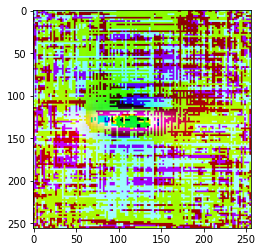

In [83]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[5]
prediction = Y_prediction[20]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()
plt.imshow(predi_img)

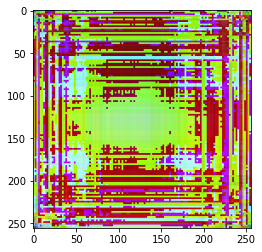

In [61]:
plt.imshow(predi_img)

(256, 256, 3)
(256, 256, 3)


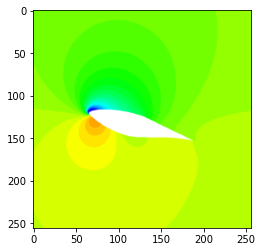

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[0]
prediction = Y_prediction[0]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()


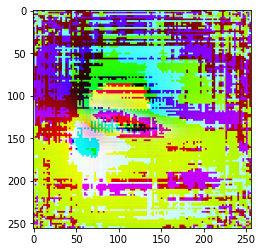

In [9]:
plt.imshow(predi_img)

In [84]:
print(test_img)
print(predi_img)
print(label)
print(prediction)

<PIL.Image.Image image mode=RGB size=256x256 at 0x20D310C0FA0>
<PIL.Image.Image image mode=RGB size=256x256 at 0x20D30FE5940>
[[[0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  ...
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]]

 [[0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  ...
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]]

 [[0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  ...
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]
  [0.58039216 1.         0.        ]]

 ...

 [[0.70980392 1.         0.        ]
  [0.70980392 1.         0.        ]
  [0.70980392 1.         0.        ]
  ...
  [0.70980392 1.         0.        ]
  [0.70980392 1.        

In [10]:
#Model U-net
tf.random.set_seed(44)

inputs = keras.Input(shape = (256,256,3), name = 'input')

x = layers.Conv2D(16, 3, activation = 'elu', padding = 'same')(inputs)

#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2))(x)

x = layers.Conv2D(32, 3, activation = 'elu', padding = 'same')(x)
skip1 = x
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2))(x)

x = layers.Conv2D(64, 3, activation = 'elu', padding = 'same')(x)
skip2 = x
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2))(x)

x = layers.Conv2D(128, 3, activation = 'elu', padding = 'same')(x)
skip3 = x
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2))(x)

x = layers.Conv2D(256, 3, activation = 'elu', padding = 'same')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2))(x)

x = layers.Conv2D(512, 3, activation = 'elu', padding = 'same')(x)

x = layers.Conv2DTranspose(256, 3, activation = 'elu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)

x = layers.Conv2DTranspose(128, 3, activation = 'elu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.add([x, skip3])

x = layers.Conv2DTranspose(64, 3, activation = 'elu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.add([x, skip2])

x = layers.Conv2DTranspose(32, 3, activation = 'elu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.add([x, skip1])

x = layers.Conv2DTranspose(16, 3, activation = 'elu', padding = 'same')(x)
x = layers.UpSampling2D((2,2))(x)


output = layers.Conv2DTranspose(3, 3, activation = 'elu', padding = 'same')(x)

#outputs = layers.Dense(1)(x)

model = keras.Model(inputs, output, name = 'unet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = model.fit(X_train,Y_train,epochs=5000, validation_data=(X_val, Y_val), batch_size=10)

#hist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32)

model.summary()
model.save('test_model2.h5')

Epoch 1/5000
42/42 [==============================] - 2s 31ms/step - loss: 5.5629 - mae: 1.6134 - val_loss: 2.5696 - val_mae: 1.5407
Epoch 2/5000
42/42 [==============================] - 1s 24ms/step - loss: 2.5708 - mae: 1.5403 - val_loss: 2.5621 - val_mae: 1.5357
Epoch 3/5000
42/42 [==============================] - 1s 24ms/step - loss: 2.5623 - mae: 1.5352 - val_loss: 2.5541 - val_mae: 1.5316
Epoch 4/5000
42/42 [==============================] - 1s 24ms/step - loss: 2.5560 - mae: 1.5320 - val_loss: 2.5485 - val_mae: 1.5299
Epoch 5/5000
42/42 [==============================] - 1s 24ms/step - loss: 2.6102 - mae: 1.5350 - val_loss: 2.6212 - val_mae: 1.5563
Epoch 6/5000
42/42 [==============================] - 1s 25ms/step - loss: 2.6018 - mae: 1.5536 - val_loss: 2.5914 - val_mae: 1.5503
Epoch 7/5000
42/42 [==============================] - 1s 25ms/step - loss: 2.5949 - mae: 1.5511 - val_loss: 2.5905 - val_mae: 1.5495
Epoch 8/5000
42/42 [==============================] - 1s 24ms/step - 

42/42 [==============================] - 1s 24ms/step - loss: 0.0425 - mae: 0.1348 - val_loss: 0.0428 - val_mae: 0.1342
Epoch 63/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0411 - mae: 0.1319 - val_loss: 0.0415 - val_mae: 0.1338
Epoch 64/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0399 - mae: 0.1300 - val_loss: 0.0409 - val_mae: 0.1320
Epoch 65/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0389 - mae: 0.1278 - val_loss: 0.0393 - val_mae: 0.1290
Epoch 66/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0380 - mae: 0.1262 - val_loss: 0.0385 - val_mae: 0.1273
Epoch 67/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0372 - mae: 0.1244 - val_loss: 0.0379 - val_mae: 0.1263
Epoch 68/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0367 - mae: 0.1234 - val_loss: 0.0373 - val_mae: 0.1244
Epoch 69/5000
42/42 [==============================] - 1s 25ms/step - loss: 

42/42 [==============================] - 1s 24ms/step - loss: 0.0285 - mae: 0.1047 - val_loss: 0.0288 - val_mae: 0.1058
Epoch 124/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0284 - mae: 0.1041 - val_loss: 0.0299 - val_mae: 0.1102
Epoch 125/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0284 - mae: 0.1045 - val_loss: 0.0288 - val_mae: 0.1037
Epoch 126/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0280 - mae: 0.1032 - val_loss: 0.0285 - val_mae: 0.1058
Epoch 127/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0278 - mae: 0.1030 - val_loss: 0.0285 - val_mae: 0.1060
Epoch 128/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0280 - mae: 0.1035 - val_loss: 0.0287 - val_mae: 0.1098
Epoch 129/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0281 - mae: 0.1041 - val_loss: 0.0283 - val_mae: 0.1038
Epoch 130/5000
42/42 [==============================] - 1s 25ms/step -

Epoch 184/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0245 - mae: 0.0956 - val_loss: 0.0252 - val_mae: 0.0984
Epoch 185/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0246 - mae: 0.0959 - val_loss: 0.0259 - val_mae: 0.0971
Epoch 186/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0244 - mae: 0.0954 - val_loss: 0.0260 - val_mae: 0.0968
Epoch 187/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0245 - mae: 0.0959 - val_loss: 0.0266 - val_mae: 0.1065
Epoch 188/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0245 - mae: 0.0961 - val_loss: 0.0255 - val_mae: 0.0998
Epoch 189/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0241 - mae: 0.0949 - val_loss: 0.0248 - val_mae: 0.0964
Epoch 190/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0246 - mae: 0.0957 - val_loss: 0.0247 - val_mae: 0.0959
Epoch 191/5000
42/42 [==============================] -

Epoch 245/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0217 - mae: 0.0864 - val_loss: 0.0227 - val_mae: 0.0880
Epoch 246/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0218 - mae: 0.0864 - val_loss: 0.0233 - val_mae: 0.0889
Epoch 247/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0216 - mae: 0.0861 - val_loss: 0.0223 - val_mae: 0.0902
Epoch 248/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0217 - mae: 0.0868 - val_loss: 0.0219 - val_mae: 0.0875
Epoch 249/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0214 - mae: 0.0855 - val_loss: 0.0224 - val_mae: 0.0890
Epoch 250/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0215 - mae: 0.0863 - val_loss: 0.0221 - val_mae: 0.0874
Epoch 251/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0219 - mae: 0.0866 - val_loss: 0.0223 - val_mae: 0.0884
Epoch 252/5000
42/42 [==============================] -

Epoch 306/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0206 - mae: 0.0828 - val_loss: 0.0212 - val_mae: 0.0856
Epoch 307/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0206 - mae: 0.0824 - val_loss: 0.0210 - val_mae: 0.0836
Epoch 308/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0204 - mae: 0.0818 - val_loss: 0.0210 - val_mae: 0.0835
Epoch 309/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0204 - mae: 0.0820 - val_loss: 0.0211 - val_mae: 0.0840
Epoch 310/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0204 - mae: 0.0818 - val_loss: 0.0211 - val_mae: 0.0835
Epoch 311/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0204 - mae: 0.0818 - val_loss: 0.0209 - val_mae: 0.0828
Epoch 312/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0205 - mae: 0.0820 - val_loss: 0.0208 - val_mae: 0.0832
Epoch 313/5000
42/42 [==============================] -

Epoch 367/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0198 - mae: 0.0793 - val_loss: 0.0202 - val_mae: 0.0806
Epoch 368/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0197 - mae: 0.0790 - val_loss: 0.0202 - val_mae: 0.0806
Epoch 369/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0197 - mae: 0.0789 - val_loss: 0.0204 - val_mae: 0.0823
Epoch 370/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0197 - mae: 0.0794 - val_loss: 0.0202 - val_mae: 0.0812
Epoch 371/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0197 - mae: 0.0792 - val_loss: 0.0203 - val_mae: 0.0802
Epoch 372/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0198 - mae: 0.0791 - val_loss: 0.0201 - val_mae: 0.0808
Epoch 373/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0197 - mae: 0.0791 - val_loss: 0.0204 - val_mae: 0.0806
Epoch 374/5000
42/42 [==============================] -

Epoch 428/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0192 - mae: 0.0773 - val_loss: 0.0198 - val_mae: 0.0804
Epoch 429/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0193 - mae: 0.0778 - val_loss: 0.0196 - val_mae: 0.0785
Epoch 430/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0192 - mae: 0.0770 - val_loss: 0.0196 - val_mae: 0.0792
Epoch 431/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0192 - mae: 0.0772 - val_loss: 0.0196 - val_mae: 0.0785
Epoch 432/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0191 - mae: 0.0769 - val_loss: 0.0197 - val_mae: 0.0787
Epoch 433/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0191 - mae: 0.0770 - val_loss: 0.0204 - val_mae: 0.0799
Epoch 434/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0191 - mae: 0.0770 - val_loss: 0.0198 - val_mae: 0.0792
Epoch 435/5000
42/42 [==============================] -

Epoch 489/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0183 - mae: 0.0750 - val_loss: 0.0187 - val_mae: 0.0763
Epoch 490/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0183 - mae: 0.0749 - val_loss: 0.0188 - val_mae: 0.0764
Epoch 491/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0183 - mae: 0.0750 - val_loss: 0.0191 - val_mae: 0.0776
Epoch 492/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0185 - mae: 0.0752 - val_loss: 0.0195 - val_mae: 0.0788
Epoch 493/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0183 - mae: 0.0750 - val_loss: 0.0189 - val_mae: 0.0764
Epoch 494/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0184 - mae: 0.0752 - val_loss: 0.0187 - val_mae: 0.0764
Epoch 495/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0182 - mae: 0.0747 - val_loss: 0.0188 - val_mae: 0.0762
Epoch 496/5000
42/42 [==============================] -

Epoch 550/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0174 - mae: 0.0732 - val_loss: 0.0179 - val_mae: 0.0741
Epoch 551/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0172 - mae: 0.0727 - val_loss: 0.0174 - val_mae: 0.0728
Epoch 552/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0170 - mae: 0.0724 - val_loss: 0.0170 - val_mae: 0.0739
Epoch 553/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0168 - mae: 0.0722 - val_loss: 0.0169 - val_mae: 0.0723
Epoch 554/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0170 - mae: 0.0724 - val_loss: 0.0169 - val_mae: 0.0723
Epoch 555/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0167 - mae: 0.0719 - val_loss: 0.0171 - val_mae: 0.0727
Epoch 556/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0170 - mae: 0.0731 - val_loss: 0.0172 - val_mae: 0.0746
Epoch 557/5000
42/42 [==============================] -

Epoch 611/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0152 - mae: 0.0685 - val_loss: 0.0165 - val_mae: 0.0732
Epoch 612/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0150 - mae: 0.0683 - val_loss: 0.0151 - val_mae: 0.0683
Epoch 613/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0149 - mae: 0.0679 - val_loss: 0.0150 - val_mae: 0.0681
Epoch 614/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0151 - mae: 0.0685 - val_loss: 0.0150 - val_mae: 0.0684
Epoch 615/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0149 - mae: 0.0679 - val_loss: 0.0157 - val_mae: 0.0692
Epoch 616/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0150 - mae: 0.0682 - val_loss: 0.0151 - val_mae: 0.0678
Epoch 617/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0152 - mae: 0.0686 - val_loss: 0.0149 - val_mae: 0.0679
Epoch 618/5000
42/42 [==============================] -

Epoch 672/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0137 - mae: 0.0659 - val_loss: 0.0143 - val_mae: 0.0671
Epoch 673/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0136 - mae: 0.0656 - val_loss: 0.0134 - val_mae: 0.0641
Epoch 674/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0136 - mae: 0.0653 - val_loss: 0.0141 - val_mae: 0.0660
Epoch 675/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0133 - mae: 0.0646 - val_loss: 0.0134 - val_mae: 0.0652
Epoch 676/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0139 - mae: 0.0662 - val_loss: 0.0132 - val_mae: 0.0647
Epoch 677/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0133 - mae: 0.0646 - val_loss: 0.0131 - val_mae: 0.0640
Epoch 678/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0136 - mae: 0.0658 - val_loss: 0.0135 - val_mae: 0.0652
Epoch 679/5000
42/42 [==============================] -

Epoch 733/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0128 - mae: 0.0634 - val_loss: 0.0127 - val_mae: 0.0640
Epoch 734/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0127 - mae: 0.0631 - val_loss: 0.0122 - val_mae: 0.0618
Epoch 735/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0128 - mae: 0.0637 - val_loss: 0.0129 - val_mae: 0.0639
Epoch 736/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0125 - mae: 0.0626 - val_loss: 0.0125 - val_mae: 0.0624
Epoch 737/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0132 - mae: 0.0651 - val_loss: 0.0131 - val_mae: 0.0649
Epoch 738/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0125 - mae: 0.0626 - val_loss: 0.0121 - val_mae: 0.0614
Epoch 739/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0125 - mae: 0.0626 - val_loss: 0.0123 - val_mae: 0.0623
Epoch 740/5000
42/42 [==============================] -

Epoch 794/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0123 - mae: 0.0625 - val_loss: 0.0117 - val_mae: 0.0602
Epoch 795/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0118 - mae: 0.0608 - val_loss: 0.0123 - val_mae: 0.0628
Epoch 796/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0116 - mae: 0.0603 - val_loss: 0.0116 - val_mae: 0.0604
Epoch 797/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0119 - mae: 0.0612 - val_loss: 0.0137 - val_mae: 0.0676
Epoch 798/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0121 - mae: 0.0623 - val_loss: 0.0124 - val_mae: 0.0616
Epoch 799/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0131 - mae: 0.0648 - val_loss: 0.0118 - val_mae: 0.0614
Epoch 800/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0119 - mae: 0.0611 - val_loss: 0.0134 - val_mae: 0.0647
Epoch 801/5000
42/42 [==============================] -

Epoch 855/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0112 - mae: 0.0593 - val_loss: 0.0112 - val_mae: 0.0601
Epoch 856/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0111 - mae: 0.0588 - val_loss: 0.0110 - val_mae: 0.0584
Epoch 857/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0114 - mae: 0.0598 - val_loss: 0.0111 - val_mae: 0.0589
Epoch 858/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0112 - mae: 0.0594 - val_loss: 0.0112 - val_mae: 0.0589
Epoch 859/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0116 - mae: 0.0605 - val_loss: 0.0110 - val_mae: 0.0590
Epoch 860/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0117 - mae: 0.0608 - val_loss: 0.0112 - val_mae: 0.0599
Epoch 861/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0115 - mae: 0.0606 - val_loss: 0.0112 - val_mae: 0.0589
Epoch 862/5000
42/42 [==============================] -

Epoch 916/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0112 - mae: 0.0595 - val_loss: 0.0117 - val_mae: 0.0628
Epoch 917/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0112 - mae: 0.0593 - val_loss: 0.0108 - val_mae: 0.0584
Epoch 918/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0108 - mae: 0.0581 - val_loss: 0.0111 - val_mae: 0.0595
Epoch 919/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0113 - mae: 0.0597 - val_loss: 0.0114 - val_mae: 0.0594
Epoch 920/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0107 - mae: 0.0578 - val_loss: 0.0107 - val_mae: 0.0574
Epoch 921/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0107 - mae: 0.0576 - val_loss: 0.0109 - val_mae: 0.0586
Epoch 922/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0108 - mae: 0.0579 - val_loss: 0.0112 - val_mae: 0.0590
Epoch 923/5000
42/42 [==============================] -

Epoch 977/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0107 - mae: 0.0579 - val_loss: 0.0103 - val_mae: 0.0564
Epoch 978/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0104 - mae: 0.0567 - val_loss: 0.0103 - val_mae: 0.0570
Epoch 979/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0105 - mae: 0.0573 - val_loss: 0.0108 - val_mae: 0.0579
Epoch 980/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0105 - mae: 0.0572 - val_loss: 0.0109 - val_mae: 0.0582
Epoch 981/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0104 - mae: 0.0567 - val_loss: 0.0101 - val_mae: 0.0563
Epoch 982/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0106 - mae: 0.0579 - val_loss: 0.0103 - val_mae: 0.0561
Epoch 983/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0106 - mae: 0.0571 - val_loss: 0.0102 - val_mae: 0.0562
Epoch 984/5000
42/42 [==============================] -

42/42 [==============================] - 1s 24ms/step - loss: 0.0101 - mae: 0.0559 - val_loss: 0.0100 - val_mae: 0.0554
Epoch 1038/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0102 - mae: 0.0560 - val_loss: 0.0108 - val_mae: 0.0596
Epoch 1039/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0102 - mae: 0.0564 - val_loss: 0.0101 - val_mae: 0.0567
Epoch 1040/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0100 - mae: 0.0557 - val_loss: 0.0101 - val_mae: 0.0567
Epoch 1041/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0103 - mae: 0.0569 - val_loss: 0.0124 - val_mae: 0.0637
Epoch 1042/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0105 - mae: 0.0572 - val_loss: 0.0102 - val_mae: 0.0570
Epoch 1043/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0102 - mae: 0.0564 - val_loss: 0.0100 - val_mae: 0.0554
Epoch 1044/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0100 - mae: 0.0558 - val_loss: 0.0109 - val_mae: 0.0600
Epoch 1098/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0112 - mae: 0.0599 - val_loss: 0.0100 - val_mae: 0.0564
Epoch 1099/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0101 - mae: 0.0558 - val_loss: 0.0108 - val_mae: 0.0585
Epoch 1100/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0105 - mae: 0.0573 - val_loss: 0.0098 - val_mae: 0.0549
Epoch 1101/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0099 - mae: 0.0552 - val_loss: 0.0104 - val_mae: 0.0574
Epoch 1102/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0103 - mae: 0.0567 - val_loss: 0.0097 - val_mae: 0.0543
Epoch 1103/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0102 - mae: 0.0563 - val_loss: 0.0109 - val_mae: 0.0583
Epoch 1104/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 25ms/step - loss: 0.0096 - mae: 0.0542 - val_loss: 0.0095 - val_mae: 0.0551
Epoch 1158/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0097 - mae: 0.0548 - val_loss: 0.0098 - val_mae: 0.0556
Epoch 1159/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0104 - mae: 0.0574 - val_loss: 0.0096 - val_mae: 0.0543
Epoch 1160/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0100 - mae: 0.0556 - val_loss: 0.0095 - val_mae: 0.0539
Epoch 1161/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0094 - val_mae: 0.0540
Epoch 1162/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0097 - mae: 0.0544 - val_loss: 0.0095 - val_mae: 0.0544
Epoch 1163/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0096 - mae: 0.0544 - val_loss: 0.0103 - val_mae: 0.0570
Epoch 1164/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 25ms/step - loss: 0.0097 - mae: 0.0548 - val_loss: 0.0092 - val_mae: 0.0529
Epoch 1218/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0094 - mae: 0.0537 - val_loss: 0.0109 - val_mae: 0.0596
Epoch 1219/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0096 - mae: 0.0545 - val_loss: 0.0094 - val_mae: 0.0538
Epoch 1220/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0096 - mae: 0.0544 - val_loss: 0.0105 - val_mae: 0.0582
Epoch 1221/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0097 - mae: 0.0547 - val_loss: 0.0100 - val_mae: 0.0559
Epoch 1222/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0094 - mae: 0.0536 - val_loss: 0.0093 - val_mae: 0.0533
Epoch 1223/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0094 - mae: 0.0536 - val_loss: 0.0098 - val_mae: 0.0563
Epoch 1224/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0094 - mae: 0.0538 - val_loss: 0.0092 - val_mae: 0.0530
Epoch 1278/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0092 - mae: 0.0532 - val_loss: 0.0093 - val_mae: 0.0530
Epoch 1279/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0096 - mae: 0.0546 - val_loss: 0.0091 - val_mae: 0.0527
Epoch 1280/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0093 - mae: 0.0536 - val_loss: 0.0105 - val_mae: 0.0577
Epoch 1281/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0103 - mae: 0.0567 - val_loss: 0.0090 - val_mae: 0.0526
Epoch 1282/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0093 - mae: 0.0531 - val_loss: 0.0097 - val_mae: 0.0547
Epoch 1283/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0094 - mae: 0.0539 - val_loss: 0.0104 - val_mae: 0.0573
Epoch 1284/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0092 - mae: 0.0532 - val_loss: 0.0097 - val_mae: 0.0556
Epoch 1338/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0100 - mae: 0.0558 - val_loss: 0.0118 - val_mae: 0.0621
Epoch 1339/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0094 - mae: 0.0537 - val_loss: 0.0093 - val_mae: 0.0534
Epoch 1340/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0095 - mae: 0.0540 - val_loss: 0.0105 - val_mae: 0.0582
Epoch 1341/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0095 - mae: 0.0543 - val_loss: 0.0089 - val_mae: 0.0521
Epoch 1342/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0093 - mae: 0.0534 - val_loss: 0.0089 - val_mae: 0.0518
Epoch 1343/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0093 - mae: 0.0535 - val_loss: 0.0095 - val_mae: 0.0543
Epoch 1344/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0520 - val_loss: 0.0088 - val_mae: 0.0521
Epoch 1398/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0091 - mae: 0.0529 - val_loss: 0.0088 - val_mae: 0.0518
Epoch 1399/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0092 - mae: 0.0533 - val_loss: 0.0103 - val_mae: 0.0572
Epoch 1400/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0090 - mae: 0.0525 - val_loss: 0.0087 - val_mae: 0.0515
Epoch 1401/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0520 - val_loss: 0.0087 - val_mae: 0.0514
Epoch 1402/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0091 - mae: 0.0529 - val_loss: 0.0107 - val_mae: 0.0594
Epoch 1403/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0092 - mae: 0.0529 - val_loss: 0.0090 - val_mae: 0.0521
Epoch 1404/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0519 - val_loss: 0.0088 - val_mae: 0.0520
Epoch 1458/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0091 - mae: 0.0531 - val_loss: 0.0091 - val_mae: 0.0529
Epoch 1459/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0518 - val_loss: 0.0088 - val_mae: 0.0520
Epoch 1460/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0091 - mae: 0.0531 - val_loss: 0.0086 - val_mae: 0.0511
Epoch 1461/5000
42/42 [==============================] - 1s 23ms/step - loss: 0.0095 - mae: 0.0545 - val_loss: 0.0087 - val_mae: 0.0512
Epoch 1462/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0518 - val_loss: 0.0088 - val_mae: 0.0519
Epoch 1463/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0519 - val_loss: 0.0086 - val_mae: 0.0511
Epoch 1464/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0519 - val_loss: 0.0088 - val_mae: 0.0523
Epoch 1518/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0516 - val_loss: 0.0086 - val_mae: 0.0516
Epoch 1519/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0515 - val_loss: 0.0085 - val_mae: 0.0506
Epoch 1520/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0512 - val_loss: 0.0086 - val_mae: 0.0511
Epoch 1521/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0521 - val_loss: 0.0087 - val_mae: 0.0514
Epoch 1522/5000
42/42 [==============================] - 1s 23ms/step - loss: 0.0089 - mae: 0.0522 - val_loss: 0.0084 - val_mae: 0.0504
Epoch 1523/5000
42/42 [==============================] - 1s 23ms/step - loss: 0.0087 - mae: 0.0514 - val_loss: 0.0085 - val_mae: 0.0508
Epoch 1524/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0086 - mae: 0.0510 - val_loss: 0.0084 - val_mae: 0.0505
Epoch 1578/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0509 - val_loss: 0.0088 - val_mae: 0.0522
Epoch 1579/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0514 - val_loss: 0.0084 - val_mae: 0.0504
Epoch 1580/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0518 - val_loss: 0.0086 - val_mae: 0.0515
Epoch 1581/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0518 - val_loss: 0.0105 - val_mae: 0.0589
Epoch 1582/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0522 - val_loss: 0.0084 - val_mae: 0.0506
Epoch 1583/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0515 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 1584/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0516 - val_loss: 0.0086 - val_mae: 0.0518
Epoch 1638/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.0521 - val_loss: 0.0083 - val_mae: 0.0501
Epoch 1639/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0084 - mae: 0.0505 - val_loss: 0.0083 - val_mae: 0.0502
Epoch 1640/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0086 - mae: 0.0513 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 1641/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0509 - val_loss: 0.0083 - val_mae: 0.0504
Epoch 1642/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0520 - val_loss: 0.0089 - val_mae: 0.0527
Epoch 1643/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0086 - mae: 0.0514 - val_loss: 0.0082 - val_mae: 0.0503
Epoch 1644/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0083 - mae: 0.0503 - val_loss: 0.0081 - val_mae: 0.0493
Epoch 1698/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0509 - val_loss: 0.0083 - val_mae: 0.0503
Epoch 1699/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0093 - val_mae: 0.0544
Epoch 1700/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0096 - val_mae: 0.0560
Epoch 1701/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0090 - mae: 0.0527 - val_loss: 0.0085 - val_mae: 0.0510
Epoch 1702/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0521 - val_loss: 0.0095 - val_mae: 0.0549
Epoch 1703/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0086 - mae: 0.0513 - val_loss: 0.0081 - val_mae: 0.0497
Epoch 1704/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0086 - val_mae: 0.0513
Epoch 1758/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0511 - val_loss: 0.0080 - val_mae: 0.0493
Epoch 1759/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0510 - val_loss: 0.0082 - val_mae: 0.0506
Epoch 1760/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0084 - mae: 0.0506 - val_loss: 0.0084 - val_mae: 0.0508
Epoch 1761/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0088 - mae: 0.0522 - val_loss: 0.0105 - val_mae: 0.0587
Epoch 1762/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0089 - mae: 0.0525 - val_loss: 0.0089 - val_mae: 0.0528
Epoch 1763/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0085 - mae: 0.0508 - val_loss: 0.0084 - val_mae: 0.0507
Epoch 1764/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0083 - mae: 0.0502 - val_loss: 0.0083 - val_mae: 0.0506
Epoch 1818/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0083 - mae: 0.0502 - val_loss: 0.0080 - val_mae: 0.0493
Epoch 1819/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0083 - mae: 0.0506 - val_loss: 0.0079 - val_mae: 0.0488
Epoch 1820/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0082 - mae: 0.0497 - val_loss: 0.0082 - val_mae: 0.0504
Epoch 1821/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0082 - mae: 0.0497 - val_loss: 0.0080 - val_mae: 0.0493
Epoch 1822/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0082 - val_mae: 0.0502
Epoch 1823/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0079 - val_mae: 0.0490
Epoch 1824/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0495 - val_loss: 0.0080 - val_mae: 0.0499
Epoch 1878/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0503 - val_loss: 0.0080 - val_mae: 0.0491
Epoch 1879/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0081 - mae: 0.0496 - val_loss: 0.0078 - val_mae: 0.0491
Epoch 1880/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0497 - val_loss: 0.0083 - val_mae: 0.0506
Epoch 1881/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0080 - val_mae: 0.0495
Epoch 1882/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0494 - val_loss: 0.0081 - val_mae: 0.0499
Epoch 1883/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0078 - val_mae: 0.0485
Epoch 1884/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0499 - val_loss: 0.0081 - val_mae: 0.0496
Epoch 1938/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0495 - val_loss: 0.0077 - val_mae: 0.0483
Epoch 1939/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0497 - val_loss: 0.0077 - val_mae: 0.0482
Epoch 1940/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0081 - mae: 0.0497 - val_loss: 0.0077 - val_mae: 0.0481
Epoch 1941/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0086 - val_mae: 0.0524
Epoch 1942/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0496 - val_loss: 0.0078 - val_mae: 0.0486
Epoch 1943/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0501 - val_loss: 0.0088 - val_mae: 0.0526
Epoch 1944/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0492 - val_loss: 0.0081 - val_mae: 0.0503
Epoch 1998/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0492 - val_loss: 0.0077 - val_mae: 0.0483
Epoch 1999/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0076 - val_mae: 0.0480
Epoch 2000/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0077 - val_mae: 0.0480
Epoch 2001/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0500 - val_loss: 0.0077 - val_mae: 0.0484
Epoch 2002/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0079 - val_mae: 0.0494
Epoch 2003/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0493 - val_loss: 0.0076 - val_mae: 0.0480
Epoch 2004/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0491 - val_loss: 0.0076 - val_mae: 0.0478
Epoch 2058/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0485 - val_loss: 0.0078 - val_mae: 0.0489
Epoch 2059/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0487 - val_loss: 0.0077 - val_mae: 0.0491
Epoch 2060/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0485 - val_loss: 0.0077 - val_mae: 0.0485
Epoch 2061/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0495 - val_loss: 0.0089 - val_mae: 0.0537
Epoch 2062/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0080 - mae: 0.0494 - val_loss: 0.0075 - val_mae: 0.0476
Epoch 2063/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0485 - val_loss: 0.0080 - val_mae: 0.0500
Epoch 2064/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0487 - val_loss: 0.0076 - val_mae: 0.0481
Epoch 2118/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0481 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2119/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mae: 0.0486 - val_loss: 0.0075 - val_mae: 0.0478
Epoch 2120/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0490 - val_loss: 0.0076 - val_mae: 0.0477
Epoch 2121/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0489 - val_loss: 0.0074 - val_mae: 0.0477
Epoch 2122/5000
42/42 [==============================] - 1s 26ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0075 - val_mae: 0.0476
Epoch 2123/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0080 - mae: 0.0496 - val_loss: 0.0077 - val_mae: 0.0486
Epoch 2124/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0479 - val_loss: 0.0073 - val_mae: 0.0471
Epoch 2178/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0480 - val_loss: 0.0077 - val_mae: 0.0492
Epoch 2179/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0481 - val_loss: 0.0074 - val_mae: 0.0475
Epoch 2180/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0480 - val_loss: 0.0073 - val_mae: 0.0470
Epoch 2181/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0481 - val_loss: 0.0075 - val_mae: 0.0479
Epoch 2182/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0487 - val_loss: 0.0076 - val_mae: 0.0484
Epoch 2183/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0481 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2184/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0483 - val_loss: 0.0073 - val_mae: 0.0470
Epoch 2238/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0478 - val_loss: 0.0079 - val_mae: 0.0495
Epoch 2239/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0480 - val_loss: 0.0074 - val_mae: 0.0474
Epoch 2240/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0479 - val_loss: 0.0073 - val_mae: 0.0472
Epoch 2241/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0482 - val_loss: 0.0074 - val_mae: 0.0477
Epoch 2242/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0479 - val_loss: 0.0073 - val_mae: 0.0473
Epoch 2243/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0479 - val_loss: 0.0075 - val_mae: 0.0479
Epoch 2244/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0478 - val_loss: 0.0071 - val_mae: 0.0464
Epoch 2298/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0475 - val_loss: 0.0073 - val_mae: 0.0470
Epoch 2299/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0479 - val_loss: 0.0072 - val_mae: 0.0466
Epoch 2300/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0475 - val_loss: 0.0072 - val_mae: 0.0466
Epoch 2301/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0071 - val_mae: 0.0464
Epoch 2302/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0073 - val_mae: 0.0474
Epoch 2303/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0073 - val_mae: 0.0473
Epoch 2304/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0478 - val_loss: 0.0072 - val_mae: 0.0470
Epoch 2358/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0071 - val_mae: 0.0465
Epoch 2359/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0481 - val_loss: 0.0083 - val_mae: 0.0518
Epoch 2360/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0072 - val_mae: 0.0466
Epoch 2361/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0077 - mae: 0.0484 - val_loss: 0.0080 - val_mae: 0.0508
Epoch 2362/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0483 - val_loss: 0.0079 - val_mae: 0.0497
Epoch 2363/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0477 - val_loss: 0.0074 - val_mae: 0.0477
Epoch 2364/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0470 - val_loss: 0.0071 - val_mae: 0.0461
Epoch 2418/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0471 - val_loss: 0.0070 - val_mae: 0.0460
Epoch 2419/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0471 - val_loss: 0.0074 - val_mae: 0.0481
Epoch 2420/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0076 - mae: 0.0483 - val_loss: 0.0070 - val_mae: 0.0463
Epoch 2421/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0075 - mae: 0.0476 - val_loss: 0.0070 - val_mae: 0.0459
Epoch 2422/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0470 - val_loss: 0.0070 - val_mae: 0.0461
Epoch 2423/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0470 - val_loss: 0.0073 - val_mae: 0.0475
Epoch 2424/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0468 - val_loss: 0.0071 - val_mae: 0.0468
Epoch 2478/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0468 - val_loss: 0.0074 - val_mae: 0.0481
Epoch 2479/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0474 - val_loss: 0.0069 - val_mae: 0.0458
Epoch 2480/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0470 - val_loss: 0.0070 - val_mae: 0.0462
Epoch 2481/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0467 - val_loss: 0.0071 - val_mae: 0.0468
Epoch 2482/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0472 - val_loss: 0.0071 - val_mae: 0.0468
Epoch 2483/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0476 - val_loss: 0.0070 - val_mae: 0.0462
Epoch 2484/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0475 - val_loss: 0.0070 - val_mae: 0.0461
Epoch 2538/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0465 - val_loss: 0.0075 - val_mae: 0.0478
Epoch 2539/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0073 - mae: 0.0472 - val_loss: 0.0069 - val_mae: 0.0456
Epoch 2540/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0466 - val_loss: 0.0069 - val_mae: 0.0461
Epoch 2541/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0476 - val_loss: 0.0068 - val_mae: 0.0455
Epoch 2542/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0465 - val_loss: 0.0069 - val_mae: 0.0459
Epoch 2543/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0465 - val_loss: 0.0069 - val_mae: 0.0454
Epoch 2544/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0467 - val_loss: 0.0068 - val_mae: 0.0453
Epoch 2598/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0466 - val_loss: 0.0068 - val_mae: 0.0454
Epoch 2599/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0073 - mae: 0.0472 - val_loss: 0.0074 - val_mae: 0.0483
Epoch 2600/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0073 - mae: 0.0471 - val_loss: 0.0069 - val_mae: 0.0459
Epoch 2601/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0072 - mae: 0.0467 - val_loss: 0.0077 - val_mae: 0.0486
Epoch 2602/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0073 - mae: 0.0473 - val_loss: 0.0068 - val_mae: 0.0452
Epoch 2603/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0462 - val_loss: 0.0069 - val_mae: 0.0461
Epoch 2604/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0461 - val_loss: 0.0068 - val_mae: 0.0454
Epoch 2658/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0467 - val_loss: 0.0068 - val_mae: 0.0457
Epoch 2659/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0472 - val_loss: 0.0084 - val_mae: 0.0523
Epoch 2660/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0470 - val_loss: 0.0069 - val_mae: 0.0458
Epoch 2661/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0469 - val_loss: 0.0068 - val_mae: 0.0458
Epoch 2662/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0462 - val_loss: 0.0069 - val_mae: 0.0462
Epoch 2663/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0463 - val_loss: 0.0068 - val_mae: 0.0453
Epoch 2664/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0467 - val_loss: 0.0069 - val_mae: 0.0463
Epoch 2718/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0467 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2719/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0468 - val_loss: 0.0077 - val_mae: 0.0497
Epoch 2720/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0471 - val_loss: 0.0075 - val_mae: 0.0490
Epoch 2721/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0469 - val_loss: 0.0066 - val_mae: 0.0449
Epoch 2722/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0466 - val_loss: 0.0069 - val_mae: 0.0462
Epoch 2723/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0462 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2724/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0458 - val_loss: 0.0067 - val_mae: 0.0450
Epoch 2778/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0459 - val_loss: 0.0068 - val_mae: 0.0459
Epoch 2779/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0466 - val_loss: 0.0067 - val_mae: 0.0449
Epoch 2780/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0071 - mae: 0.0465 - val_loss: 0.0067 - val_mae: 0.0453
Epoch 2781/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0462 - val_loss: 0.0066 - val_mae: 0.0445
Epoch 2782/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0460 - val_loss: 0.0066 - val_mae: 0.0449
Epoch 2783/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0460 - val_loss: 0.0076 - val_mae: 0.0493
Epoch 2784/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0458 - val_loss: 0.0066 - val_mae: 0.0450
Epoch 2838/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0455 - val_loss: 0.0066 - val_mae: 0.0451
Epoch 2839/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0457 - val_loss: 0.0068 - val_mae: 0.0460
Epoch 2840/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0069 - mae: 0.0460 - val_loss: 0.0066 - val_mae: 0.0448
Epoch 2841/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0070 - mae: 0.0460 - val_loss: 0.0074 - val_mae: 0.0479
Epoch 2842/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0478 - val_loss: 0.0068 - val_mae: 0.0460
Epoch 2843/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0455 - val_loss: 0.0066 - val_mae: 0.0447
Epoch 2844/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0458 - val_loss: 0.0065 - val_mae: 0.0443
Epoch 2898/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0460 - val_loss: 0.0065 - val_mae: 0.0445
Epoch 2899/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0460 - val_loss: 0.0065 - val_mae: 0.0446
Epoch 2900/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0069 - mae: 0.0457 - val_loss: 0.0066 - val_mae: 0.0450
Epoch 2901/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0457 - val_loss: 0.0065 - val_mae: 0.0445
Epoch 2902/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0455 - val_loss: 0.0066 - val_mae: 0.0450
Epoch 2903/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0464 - val_loss: 0.0068 - val_mae: 0.0459
Epoch 2904/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0452 - val_loss: 0.0071 - val_mae: 0.0478
Epoch 2958/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0070 - mae: 0.0462 - val_loss: 0.0065 - val_mae: 0.0444
Epoch 2959/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0461 - val_loss: 0.0067 - val_mae: 0.0456
Epoch 2960/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0453 - val_loss: 0.0064 - val_mae: 0.0444
Epoch 2961/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0453 - val_loss: 0.0066 - val_mae: 0.0454
Epoch 2962/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0064 - val_mae: 0.0444
Epoch 2963/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0065 - val_mae: 0.0443
Epoch 2964/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 25ms/step - loss: 0.0068 - mae: 0.0457 - val_loss: 0.0067 - val_mae: 0.0457
Epoch 3018/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0453 - val_loss: 0.0067 - val_mae: 0.0459
Epoch 3019/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0066 - val_mae: 0.0451
Epoch 3020/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0064 - val_mae: 0.0440
Epoch 3021/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0450 - val_loss: 0.0063 - val_mae: 0.0440
Epoch 3022/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0453 - val_loss: 0.0063 - val_mae: 0.0440
Epoch 3023/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0456 - val_loss: 0.0066 - val_mae: 0.0449
Epoch 3024/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0451 - val_loss: 0.0065 - val_mae: 0.0452
Epoch 3078/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0066 - mae: 0.0450 - val_loss: 0.0063 - val_mae: 0.0439
Epoch 3079/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0067 - mae: 0.0451 - val_loss: 0.0064 - val_mae: 0.0446
Epoch 3080/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0066 - val_mae: 0.0456
Epoch 3081/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0067 - mae: 0.0452 - val_loss: 0.0064 - val_mae: 0.0442
Epoch 3082/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0451 - val_loss: 0.0063 - val_mae: 0.0440
Epoch 3083/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0066 - mae: 0.0450 - val_loss: 0.0063 - val_mae: 0.0441
Epoch 3084/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0071 - val_mae: 0.0477
Epoch 3138/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0068 - mae: 0.0458 - val_loss: 0.0064 - val_mae: 0.0447
Epoch 3139/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0455 - val_loss: 0.0063 - val_mae: 0.0438
Epoch 3140/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0448 - val_loss: 0.0062 - val_mae: 0.0437
Epoch 3141/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0449 - val_loss: 0.0062 - val_mae: 0.0436
Epoch 3142/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0448 - val_loss: 0.0063 - val_mae: 0.0441
Epoch 3143/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0063 - val_mae: 0.0441
Epoch 3144/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0063 - val_mae: 0.0441
Epoch 3198/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0446 - val_loss: 0.0062 - val_mae: 0.0434
Epoch 3199/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0450 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 3200/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0452 - val_loss: 0.0062 - val_mae: 0.0437
Epoch 3201/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0063 - val_mae: 0.0440
Epoch 3202/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0062 - val_mae: 0.0437
Epoch 3203/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0453 - val_loss: 0.0063 - val_mae: 0.0438
Epoch 3204/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0445 - val_loss: 0.0062 - val_mae: 0.0438
Epoch 3258/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0447 - val_loss: 0.0062 - val_mae: 0.0436
Epoch 3259/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0445 - val_loss: 0.0061 - val_mae: 0.0433
Epoch 3260/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0448 - val_loss: 0.0062 - val_mae: 0.0434
Epoch 3261/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0447 - val_loss: 0.0062 - val_mae: 0.0440
Epoch 3262/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0445 - val_loss: 0.0063 - val_mae: 0.0443
Epoch 3263/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mae: 0.0454 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 3264/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 25ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0066 - val_mae: 0.0461
Epoch 3318/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0066 - mae: 0.0451 - val_loss: 0.0062 - val_mae: 0.0438
Epoch 3319/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0065 - mae: 0.0447 - val_loss: 0.0061 - val_mae: 0.0432
Epoch 3320/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0061 - val_mae: 0.0433
Epoch 3321/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0062 - val_mae: 0.0435
Epoch 3322/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0446 - val_loss: 0.0061 - val_mae: 0.0435
Epoch 3323/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0063 - val_mae: 0.0438
Epoch 3324/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0446 - val_loss: 0.0062 - val_mae: 0.0439
Epoch 3378/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0062 - val_mae: 0.0442
Epoch 3379/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0446 - val_loss: 0.0060 - val_mae: 0.0431
Epoch 3380/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0448 - val_loss: 0.0065 - val_mae: 0.0453
Epoch 3381/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0446 - val_loss: 0.0063 - val_mae: 0.0445
Epoch 3382/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0450 - val_loss: 0.0062 - val_mae: 0.0440
Epoch 3383/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0061 - val_mae: 0.0432
Epoch 3384/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0060 - val_mae: 0.0431
Epoch 3438/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0060 - val_mae: 0.0432
Epoch 3439/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0060 - val_mae: 0.0431
Epoch 3440/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0442 - val_loss: 0.0066 - val_mae: 0.0460
Epoch 3441/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0066 - mae: 0.0454 - val_loss: 0.0063 - val_mae: 0.0447
Epoch 3442/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0442 - val_loss: 0.0060 - val_mae: 0.0429
Epoch 3443/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0444 - val_loss: 0.0062 - val_mae: 0.0440
Epoch 3444/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0060 - val_mae: 0.0433
Epoch 3498/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0060 - val_mae: 0.0432
Epoch 3499/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0062 - val_mae: 0.0445
Epoch 3500/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0071 - val_mae: 0.0485
Epoch 3501/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0448 - val_loss: 0.0061 - val_mae: 0.0434
Epoch 3502/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0442 - val_loss: 0.0060 - val_mae: 0.0432
Epoch 3503/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0060 - val_mae: 0.0431
Epoch 3504/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0061 - val_mae: 0.0432
Epoch 3558/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0061 - val_mae: 0.0438
Epoch 3559/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0060 - val_mae: 0.0432
Epoch 3560/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0439 - val_loss: 0.0059 - val_mae: 0.0428
Epoch 3561/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0061 - val_mae: 0.0438
Epoch 3562/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0439 - val_loss: 0.0059 - val_mae: 0.0427
Epoch 3563/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0439 - val_loss: 0.0059 - val_mae: 0.0428
Epoch 3564/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0439 - val_loss: 0.0059 - val_mae: 0.0425
Epoch 3618/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0065 - mae: 0.0451 - val_loss: 0.0064 - val_mae: 0.0453
Epoch 3619/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0439 - val_loss: 0.0063 - val_mae: 0.0449
Epoch 3620/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0063 - mae: 0.0440 - val_loss: 0.0059 - val_mae: 0.0429
Epoch 3621/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0062 - mae: 0.0438 - val_loss: 0.0059 - val_mae: 0.0428
Epoch 3622/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0439 - val_loss: 0.0059 - val_mae: 0.0426
Epoch 3623/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0442 - val_loss: 0.0062 - val_mae: 0.0437
Epoch 3624/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0059 - val_mae: 0.0428
Epoch 3678/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0441 - val_loss: 0.0058 - val_mae: 0.0423
Epoch 3679/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0058 - val_mae: 0.0425
Epoch 3680/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0442 - val_loss: 0.0059 - val_mae: 0.0427
Epoch 3681/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0427
Epoch 3682/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0423
Epoch 3683/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0436 - val_loss: 0.0058 - val_mae: 0.0425
Epoch 3684/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0436 - val_loss: 0.0058 - val_mae: 0.0424
Epoch 3738/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0433 - val_loss: 0.0059 - val_mae: 0.0426
Epoch 3739/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0423
Epoch 3740/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0434 - val_loss: 0.0062 - val_mae: 0.0445
Epoch 3741/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0438 - val_loss: 0.0060 - val_mae: 0.0437
Epoch 3742/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0058 - val_mae: 0.0422
Epoch 3743/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0059 - val_mae: 0.0432
Epoch 3744/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0434 - val_loss: 0.0058 - val_mae: 0.0425
Epoch 3798/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0425
Epoch 3799/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0422
Epoch 3800/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0422
Epoch 3801/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0423
Epoch 3802/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0433 - val_loss: 0.0057 - val_mae: 0.0422
Epoch 3803/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0433 - val_loss: 0.0057 - val_mae: 0.0422
Epoch 3804/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0431 - val_loss: 0.0057 - val_mae: 0.0423
Epoch 3858/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0437 - val_loss: 0.0058 - val_mae: 0.0426
Epoch 3859/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0434 - val_loss: 0.0057 - val_mae: 0.0421
Epoch 3860/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0433 - val_loss: 0.0057 - val_mae: 0.0423
Epoch 3861/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0058 - val_mae: 0.0428
Epoch 3862/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0063 - mae: 0.0445 - val_loss: 0.0058 - val_mae: 0.0424
Epoch 3863/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0420
Epoch 3864/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 25ms/step - loss: 0.0060 - mae: 0.0433 - val_loss: 0.0057 - val_mae: 0.0421
Epoch 3918/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0061 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0422
Epoch 3919/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0432 - val_loss: 0.0058 - val_mae: 0.0427
Epoch 3920/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0434 - val_loss: 0.0059 - val_mae: 0.0432
Epoch 3921/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0062 - mae: 0.0442 - val_loss: 0.0057 - val_mae: 0.0420
Epoch 3922/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0436 - val_loss: 0.0057 - val_mae: 0.0421
Epoch 3923/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0437 - val_loss: 0.0065 - val_mae: 0.0457
Epoch 3924/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0431 - val_loss: 0.0056 - val_mae: 0.0420
Epoch 3978/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 3979/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 3980/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0434 - val_loss: 0.0056 - val_mae: 0.0421
Epoch 3981/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0431 - val_loss: 0.0058 - val_mae: 0.0430
Epoch 3982/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0060 - mae: 0.0434 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 3983/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 3984/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0432 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 4038/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0056 - val_mae: 0.0417
Epoch 4039/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0057 - val_mae: 0.0424
Epoch 4040/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0061 - mae: 0.0439 - val_loss: 0.0056 - val_mae: 0.0417
Epoch 4041/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0430 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 4042/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0059 - val_mae: 0.0433
Epoch 4043/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0057 - val_mae: 0.0420
Epoch 4044/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 4098/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0427 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 4099/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0415
Epoch 4100/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0434 - val_loss: 0.0058 - val_mae: 0.0429
Epoch 4101/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0060 - mae: 0.0431 - val_loss: 0.0056 - val_mae: 0.0422
Epoch 4102/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0433 - val_loss: 0.0055 - val_mae: 0.0416
Epoch 4103/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0418
Epoch 4104/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0428 - val_loss: 0.0055 - val_mae: 0.0415
Epoch 4158/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0059 - mae: 0.0428 - val_loss: 0.0056 - val_mae: 0.0419
Epoch 4159/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0060 - mae: 0.0432 - val_loss: 0.0057 - val_mae: 0.0421
Epoch 4160/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0427 - val_loss: 0.0055 - val_mae: 0.0416
Epoch 4161/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0057 - val_mae: 0.0421
Epoch 4162/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0060 - mae: 0.0433 - val_loss: 0.0055 - val_mae: 0.0414
Epoch 4163/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0056 - val_mae: 0.0424
Epoch 4164/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0055 - val_mae: 0.0416
Epoch 4218/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0421
Epoch 4219/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0424 - val_loss: 0.0056 - val_mae: 0.0420
Epoch 4220/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0058 - mae: 0.0427 - val_loss: 0.0057 - val_mae: 0.0426
Epoch 4221/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0420
Epoch 4222/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0424 - val_loss: 0.0055 - val_mae: 0.0415
Epoch 4223/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0426 - val_loss: 0.0055 - val_mae: 0.0416
Epoch 4224/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0423 - val_loss: 0.0054 - val_mae: 0.0414
Epoch 4278/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0058 - mae: 0.0426 - val_loss: 0.0055 - val_mae: 0.0413
Epoch 4279/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0057 - val_mae: 0.0427
Epoch 4280/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0057 - val_mae: 0.0424
Epoch 4281/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0426 - val_loss: 0.0055 - val_mae: 0.0417
Epoch 4282/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0430 - val_loss: 0.0054 - val_mae: 0.0413
Epoch 4283/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0056 - val_mae: 0.0424
Epoch 4284/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0423 - val_loss: 0.0056 - val_mae: 0.0420
Epoch 4338/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0424 - val_loss: 0.0054 - val_mae: 0.0412
Epoch 4339/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0054 - val_mae: 0.0410
Epoch 4340/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0422 - val_loss: 0.0054 - val_mae: 0.0411
Epoch 4341/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0422 - val_loss: 0.0054 - val_mae: 0.0410
Epoch 4342/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0056 - val_mae: 0.0422
Epoch 4343/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0425 - val_loss: 0.0054 - val_mae: 0.0412
Epoch 4344/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0423 - val_loss: 0.0054 - val_mae: 0.0412
Epoch 4398/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0422 - val_loss: 0.0054 - val_mae: 0.0411
Epoch 4399/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0421 - val_loss: 0.0055 - val_mae: 0.0418
Epoch 4400/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0427 - val_loss: 0.0055 - val_mae: 0.0419
Epoch 4401/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0424 - val_loss: 0.0055 - val_mae: 0.0414
Epoch 4402/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0424 - val_loss: 0.0054 - val_mae: 0.0413
Epoch 4403/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0427 - val_loss: 0.0054 - val_mae: 0.0410
Epoch 4404/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0421 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4458/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0423 - val_loss: 0.0053 - val_mae: 0.0410
Epoch 4459/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0424 - val_loss: 0.0055 - val_mae: 0.0418
Epoch 4460/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0059 - mae: 0.0432 - val_loss: 0.0055 - val_mae: 0.0416
Epoch 4461/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0426 - val_loss: 0.0053 - val_mae: 0.0411
Epoch 4462/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0422 - val_loss: 0.0053 - val_mae: 0.0410
Epoch 4463/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0423 - val_loss: 0.0053 - val_mae: 0.0408
Epoch 4464/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4518/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0420 - val_loss: 0.0055 - val_mae: 0.0414
Epoch 4519/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0058 - mae: 0.0429 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4520/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0411
Epoch 4521/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0057 - mae: 0.0420 - val_loss: 0.0054 - val_mae: 0.0413
Epoch 4522/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4523/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0055 - val_mae: 0.0422
Epoch 4524/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4578/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0407
Epoch 4579/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0410
Epoch 4580/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0053 - val_mae: 0.0408
Epoch 4581/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0052 - val_mae: 0.0407
Epoch 4582/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0053 - val_mae: 0.0410
Epoch 4583/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0057 - mae: 0.0421 - val_loss: 0.0053 - val_mae: 0.0409
Epoch 4584/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4638/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4639/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0053 - val_mae: 0.0408
Epoch 4640/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4641/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0058 - val_mae: 0.0435
Epoch 4642/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0053 - val_mae: 0.0412
Epoch 4643/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0057 - mae: 0.0421 - val_loss: 0.0053 - val_mae: 0.0412
Epoch 4644/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0053 - val_mae: 0.0406
Epoch 4698/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 4699/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0054 - val_mae: 0.0415
Epoch 4700/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4701/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0053 - val_mae: 0.0414
Epoch 4702/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0056 - val_mae: 0.0426
Epoch 4703/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4704/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4758/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0052 - val_mae: 0.0404
Epoch 4759/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0415 - val_loss: 0.0053 - val_mae: 0.0412
Epoch 4760/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0419 - val_loss: 0.0052 - val_mae: 0.0407
Epoch 4761/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4762/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0052 - val_mae: 0.0403
Epoch 4763/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4764/5000
42/42 [==============================] - 1s 25ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0056 - val_mae: 0.0428
Epoch 4818/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0421 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4819/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0415 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4820/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4821/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4822/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0415 - val_loss: 0.0051 - val_mae: 0.0403
Epoch 4823/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0054 - val_mae: 0.0410
Epoch 4824/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0052 - val_mae: 0.0405
Epoch 4878/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4879/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4880/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4881/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0056 - mae: 0.0418 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4882/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0415 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4883/5000
42/42 [==============================] - 1s 25ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0051 - val_mae: 0.0404
Epoch 4884/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0415 - val_loss: 0.0052 - val_mae: 0.0406
Epoch 4938/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4939/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0054 - mae: 0.0413 - val_loss: 0.0051 - val_mae: 0.0401
Epoch 4940/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4941/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0051 - val_mae: 0.0401
Epoch 4942/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0054 - mae: 0.0413 - val_loss: 0.0051 - val_mae: 0.0401
Epoch 4943/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0056 - mae: 0.0420 - val_loss: 0.0052 - val_mae: 0.0410
Epoch 4944/5000
42/42 [==============================] - 1s 24ms

42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0416 - val_loss: 0.0051 - val_mae: 0.0402
Epoch 4998/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0055 - mae: 0.0414 - val_loss: 0.0051 - val_mae: 0.0404
Epoch 4999/5000
42/42 [==============================] - 1s 24ms/step - loss: 0.0054 - mae: 0.0413 - val_loss: 0.0051 - val_mae: 0.0403
Epoch 5000/5000
42/42 [==============================] - 1s 23ms/step - loss: 0.0055 - mae: 0.0417 - val_loss: 0.0054 - val_mae: 0.0418
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                              

(256, 256, 3)
(256, 256, 3)


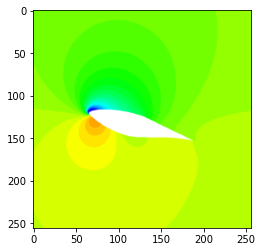

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[0]
prediction = Y_prediction[0]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()


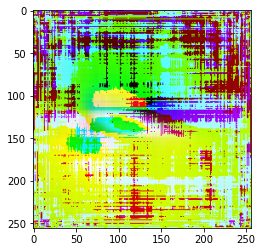

In [13]:
plt.imshow(predi_img)

In [ ]:
input_e = tf.keras.Input(shape=(256,256,3))

conv1 = layers.Conv2D(32, (3,3), activation='relu', padding = 'same')(input_e)
mp1 = layers.MaxPooling2D((2,2))(conv1)
        
conv2 = layers.Conv2D(64, (3,3), activation='relu', padding = 'same')(mp1)
mp2 = layers.MaxPooling2D((2,2))(conv2)
        
conv3 = layers.Conv2D(128, (3,3), activation='relu', padding = 'same')(mp2)
mp3 = layers.MaxPooling2D((2,2))(conv3)

conv4 = layers.Conv2D(256, (3,3), activation='relu', padding = 'same')(mp3)
mp4 = layers.MaxPooling2D((2,2))(conv4)
        
output_e = layers.Conv2D(512, (3,3), activation='relu', padding = 'same')(mp4)

convt1 = layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same')(output_e)
upsamp1 = layers.UpSampling2D((2,2))(convt1)
skipcon1 = layers.Concatenate(axis=3)([conv4, upsamp1])
conv6 = layers.Conv2D(256, (3,3), activation = 'relu', padding='same')(skipcon1)

convt2 = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(conv6)
upsamp2 = layers.UpSampling2D((2,2))(convt2)
skipcon2 = layers.Concatenate(axis=3)([conv3, upsamp2])
conv7 = layers.Conv2D(128, (3,3), activation = 'relu', padding='same')(skipcon2)

convt3 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(conv7)
upsamp3 = layers.UpSampling2D((2,2))(convt3)
skipcon3 = layers.Concatenate(axis=3)([conv2, upsamp3])
conv8 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(skipcon3)

convt4 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(conv8)
upsamp4 = layers.UpSampling2D((2,2))(convt4)
skipcon4 = layers.Concatenate(axis=3)([conv1, upsamp4])
conv9 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(skipcon4)

output_d = layers.Conv2DTranspose(3, (3,3), activation='relu', padding='same')(conv9)

model = keras.Model(inputs_e, output_d, name = 'unet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = model.fit(X_train,Y_train,epochs=5000, validation_data=(X_val, Y_val), batch_size=10)

#hist = model.fit(X_tr,Y_tr['M'],epochs=500, validation_data=(X_vid, Y_vid['M']), batch_size=32)

model.summary()
model.save('test_model2.h5')

(256, 256, 3)
(256, 256, 3)


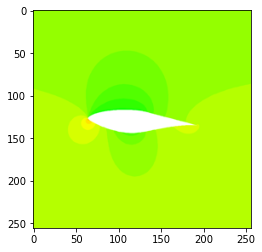

In [91]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = model.predict(X_test)

label = Y_test[0]
prediction = Y_prediction[0]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()


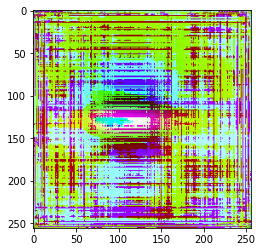

In [92]:
plt.imshow(predi_img)

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
transfer_model.trainable = True
transfer_model.summary()
test_model = Sequential()
test_model.add(transfer_model)
test_model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(3, kernel_size=3, padding='same', activation='relu'))


test_model.summary()
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = test_model.fit(X_train,Y_train,epochs=5000, validation_data=(X_val, Y_val), batch_size=10)
model.save('test_model3.h5')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

42/42 [==============================] - 6s 135ms/step - loss: 0.0335 - mae: 0.0943 - val_loss: 0.0345 - val_mae: 0.0977
Epoch 23/5000
42/42 [==============================] - 6s 135ms/step - loss: 0.0337 - mae: 0.0959 - val_loss: 0.0343 - val_mae: 0.0974
Epoch 24/5000
42/42 [==============================] - 6s 135ms/step - loss: 0.0332 - mae: 0.0938 - val_loss: 0.0350 - val_mae: 0.0944
Epoch 25/5000
42/42 [==============================] - 5s 130ms/step - loss: 0.0334 - mae: 0.0947 - val_loss: 0.0348 - val_mae: 0.0924
Epoch 26/5000
42/42 [==============================] - 5s 130ms/step - loss: 0.0333 - mae: 0.0942 - val_loss: 0.0348 - val_mae: 0.0939
Epoch 27/5000
42/42 [==============================] - 5s 131ms/step - loss: 0.0334 - mae: 0.0939 - val_loss: 0.0348 - val_mae: 0.1042
Epoch 28/5000
42/42 [==============================] - 6s 133ms/step - loss: 0.0333 - mae: 0.0940 - val_loss: 0.0345 - val_mae: 0.1026
Epoch 29/5000
42/42 [==============================] - 6s 132ms/step 

Epoch 83/5000
42/42 [==============================] - 6s 131ms/step - loss: 0.0323 - mae: 0.0919 - val_loss: 0.0335 - val_mae: 0.0941
Epoch 84/5000
42/42 [==============================] - 6s 131ms/step - loss: 0.0322 - mae: 0.0910 - val_loss: 0.0334 - val_mae: 0.0970
Epoch 85/5000
42/42 [==============================] - 5s 131ms/step - loss: 0.0323 - mae: 0.0917 - val_loss: 0.0333 - val_mae: 0.0952
Epoch 86/5000
42/42 [==============================] - 5s 131ms/step - loss: 0.0323 - mae: 0.0919 - val_loss: 0.0335 - val_mae: 0.0987
Epoch 87/5000
42/42 [==============================] - 5s 125ms/step - loss: 0.0323 - mae: 0.0917 - val_loss: 0.0333 - val_mae: 0.0929
Epoch 88/5000
42/42 [==============================] - 5s 129ms/step - loss: 0.0322 - mae: 0.0915 - val_loss: 0.0336 - val_mae: 0.0915
Epoch 89/5000
42/42 [==============================] - 5s 131ms/step - loss: 0.0322 - mae: 0.0916 - val_loss: 0.0339 - val_mae: 0.0917
Epoch 90/5000
42/42 [==============================] - 

42/42 [==============================] - 6s 133ms/step - loss: 0.0317 - mae: 0.0906 - val_loss: 0.0333 - val_mae: 0.0906
Epoch 144/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0317 - mae: 0.0901 - val_loss: 0.0331 - val_mae: 0.0987
Epoch 145/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0317 - mae: 0.0900 - val_loss: 0.0329 - val_mae: 0.0949
Epoch 146/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0317 - mae: 0.0906 - val_loss: 0.0333 - val_mae: 0.0988
Epoch 147/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0317 - mae: 0.0904 - val_loss: 0.0328 - val_mae: 0.0933
Epoch 148/5000
42/42 [==============================] - 6s 134ms/step - loss: 0.0317 - mae: 0.0905 - val_loss: 0.0329 - val_mae: 0.0918
Epoch 149/5000
42/42 [==============================] - 6s 133ms/step - loss: 0.0318 - mae: 0.0906 - val_loss: 0.0328 - val_mae: 0.0945
Epoch 150/5000
42/42 [==============================] - 6s 132m

42/42 [==============================] - 5s 131ms/step - loss: 0.0308 - mae: 0.0880 - val_loss: 0.0318 - val_mae: 0.0932
Epoch 204/5000
42/42 [==============================] - 6s 131ms/step - loss: 0.0307 - mae: 0.0879 - val_loss: 0.0318 - val_mae: 0.0920
Epoch 205/5000
42/42 [==============================] - 5s 129ms/step - loss: 0.0306 - mae: 0.0874 - val_loss: 0.0317 - val_mae: 0.0914
Epoch 206/5000
42/42 [==============================] - 5s 131ms/step - loss: 0.0307 - mae: 0.0883 - val_loss: 0.0317 - val_mae: 0.0918
Epoch 207/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0307 - mae: 0.0882 - val_loss: 0.0316 - val_mae: 0.0918
Epoch 208/5000
42/42 [==============================] - 6s 133ms/step - loss: 0.0306 - mae: 0.0880 - val_loss: 0.0316 - val_mae: 0.0896
Epoch 209/5000
42/42 [==============================] - 6s 132ms/step - loss: 0.0304 - mae: 0.0873 - val_loss: 0.0315 - val_mae: 0.0914
Epoch 210/5000
42/42 [==============================] - 6s 132m

(256, 256, 3)
(256, 256, 3)


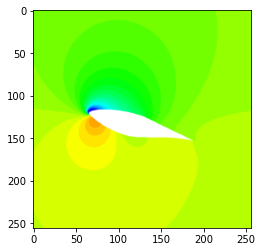

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = test_model.predict(X_test)

label = Y_test[0]
prediction = Y_prediction[0]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()

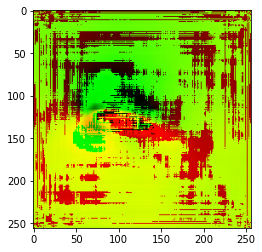

In [26]:
plt.imshow(predi_img)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
Y_prediction = test_model.predict(X_test)

label = Y_test[0]
prediction = Y_prediction[0]
test_img= Image.fromarray((label*255).astype(np.uint8))
predi_img= Image.fromarray((prediction*255).astype(np.uint8))
plt.imshow(test_img)
print(Y_test[0].shape)
print(Y_prediction[0].shape)
# img_test_label = Image.fromarray(img_test_label)
# img_test_label.show()

In [ ]:
plt.imshow(predi_img)

In [ ]:
"""
레이놀즈 수를 곱하여 입력값에 넣었다.
"""
import numpy as np
import re
import os
from PIL import Image
from keras.preprocessing.image import img_to_array
current_path = os.path.abspath('')
input_img_path = os.path.join(current_path,"input_img")
target_img_path = os.path.join(current_path,"target_img")
input_files = os.listdir(input_img_path)
target_files = os.listdir(target_img_path)
datasets = []
i = 0
test_data = np.array([])
for input_file, target_file in zip(input_files, target_files):
    dataset= []
    plus_input = []
    mul_input = []
    input_pro = []
    name = str(input_file)
    #레이놀즈 수 파일 이름에서 추출
    R = float(name[5]+"."+name[6])*10**int(name[7])/(1.3*(10**6))
    #인풋 이미지 파일 경로로 들어가서 인풋 이미지 전처리 과정
    os.chdir(input_img_path)
    input_img = Image.open(input_file)
    #이미지 리사이징
    input_img = input_img.resize((256, 256))
    #이미지 nunpy배열로 변환
    input_img_tensor = img_to_array(input_img)
    input_img_tensor = input_img_tensor.reshape(196608).astype('float64')/ 255
    #타겟 이미지 파일 경로로 들어가서 전처리 과정
    os.chdir(target_img_path)
    target_img = Image.open(target_file)
    target_img = target_img.resize((256,256))
    #타겟 이미지는 1차원 배열로 생성
    target_img_tensor = img_to_array(target_img)
    target_img_tensor = target_img_tensor.reshape(196608).astype('float64')/ 255
    plus_input = input_img_tensor * R
    dataset = np.concatenate((input_img_tensor,plus_input), axis = 0)
    dataset = np.concatenate((dataset,target_img_tensor), axis = 0)
    datasets.insert(i,dataset)
    i += 1
    os.chdir('..')
datasets = np.array(datasets)
#[:,:196608]인풋 이미지,[:,196608:393216]레이놀즈수,[:,393216:]타겟 이미지
np.save("test4.npy", datasets)
print(datasets.shape)

In [ ]:

dataset = np.load('test2.npy', allow_pickle=True)
X = dataset[:,65536:131072]
Y = dataset[:,131072:]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state =1)
X_test, X_val,Y_test, Y_val = train_test_split(X_test,Y_test,test_size=0.5,random_state=1)
X_train = X_train.reshape(X_train.shape[0], 256,256,1)
X_test = X_test.reshape(X_test.shape[0], 256,256,1)
X_val = X_val.reshape(X_val.shape[0], 256,256,1)
tf.random.set_seed(44)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
transfer_model.trainable = False
transfer_model.summary()
test_model = Sequential()
test_model.add(transfer_model)
test_model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
test_model.add(UpSampling2D())
test_model.add(Conv2D(3, kernel_size=3, padding='same', activation='relu'))


test_model.summary()
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0012, decay = 0.013),loss='mse', metrics=['mae'])
history = test_model.fit(X_train,Y_train,epochs=5000, validation_data=(X_val, Y_val), batch_size=32)
model.save('test_model3.h5')